In [1]:
import Experiments_Module as exp

In [2]:
from sklearn.ensemble import IsolationForest
from sklearn.metrics import roc_auc_score
from scipy.linalg import qr
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
get_ipython().magic('matplotlib inline')

from pylab import rcParams
rcParams['figure.figsize'] = 14, 12  # делаем картинки крупнее
get_ipython().magic("config InlineBackend.figure_format = 'retina'  # делаем картинки красивее")

pd.options.display.max_rows = 20

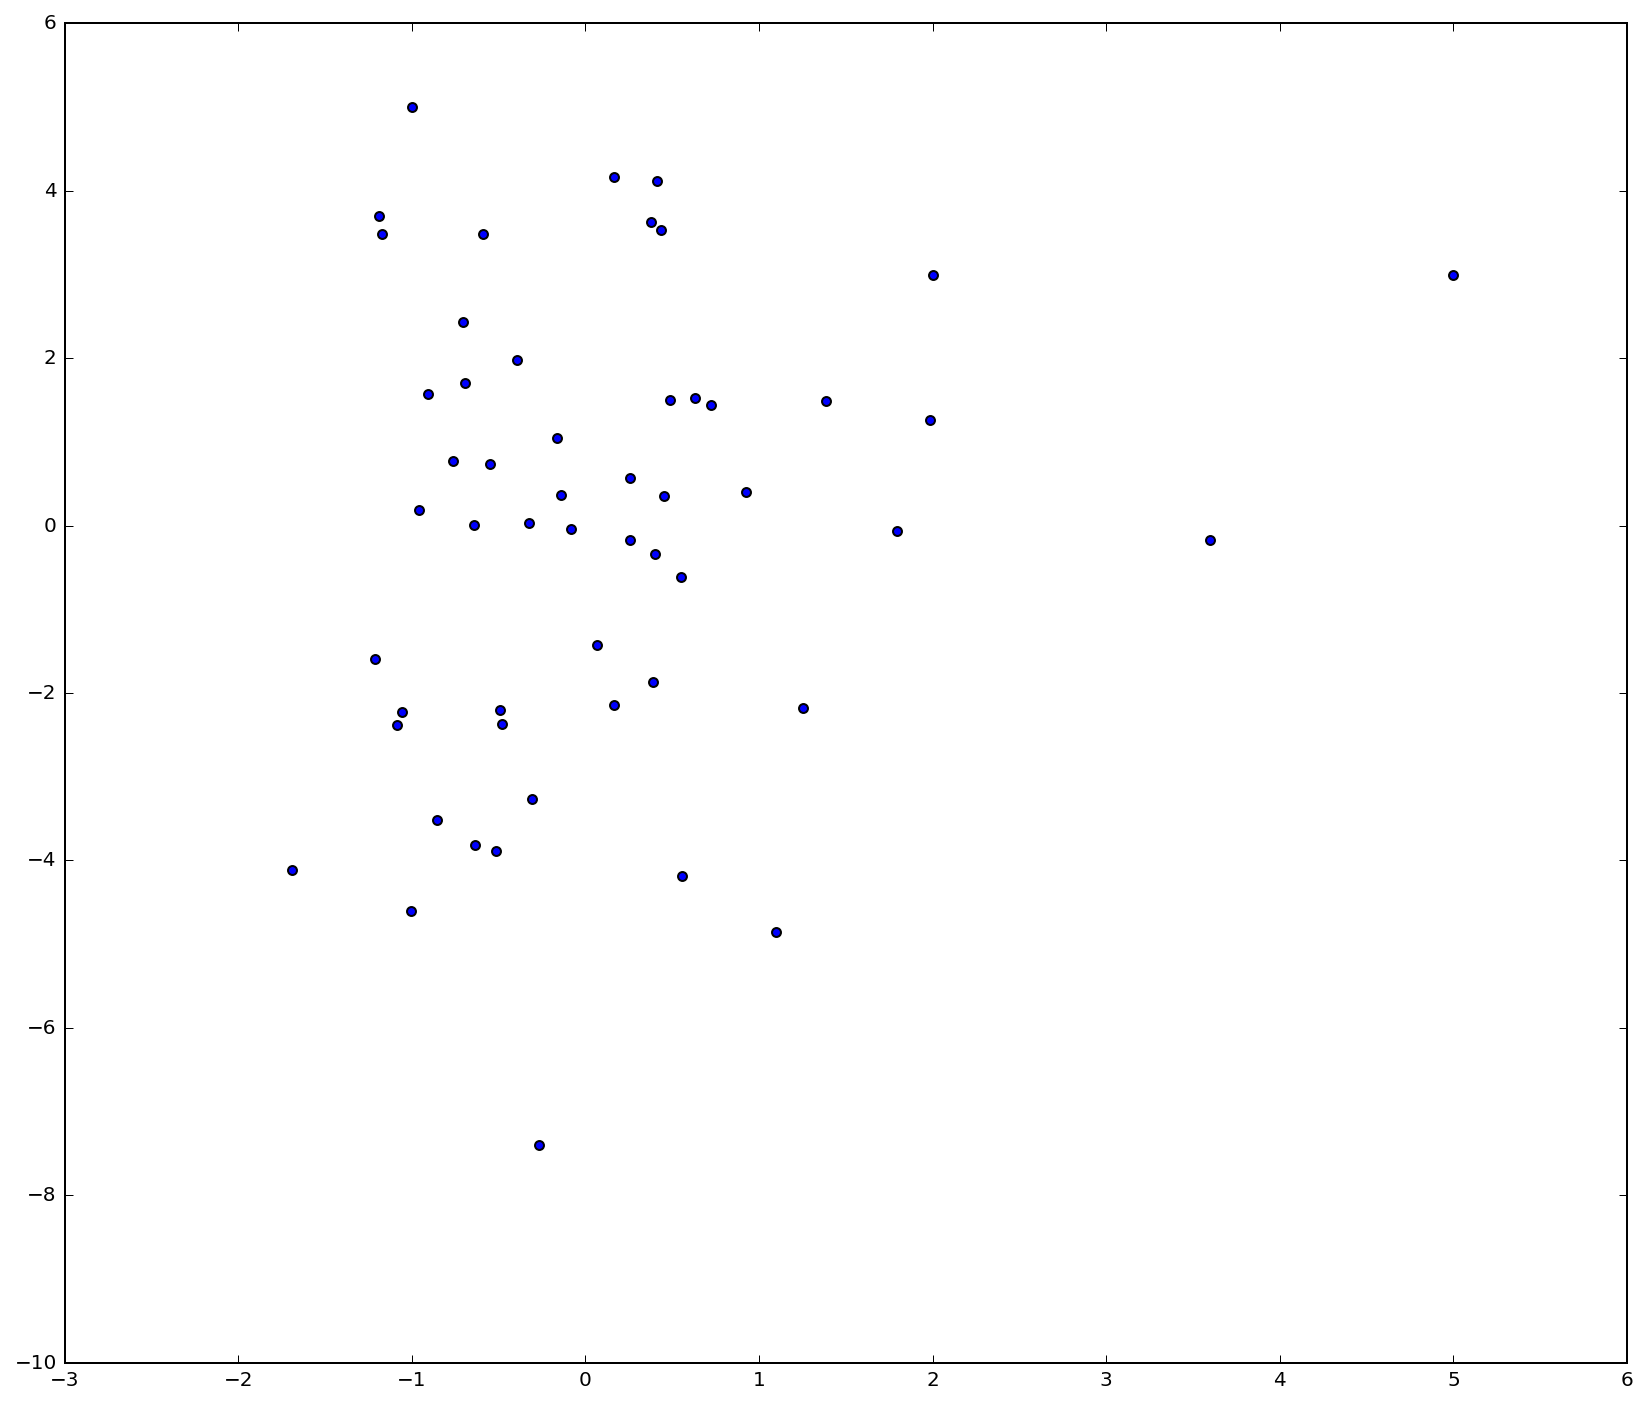

In [3]:
X = np.random.normal(scale=[1, 3], size=(50, 2))
X = np.vstack([X, np.array([[2, 3], [-1, 5], [5, 3]])])
plt.scatter(X[:, 0], X[:, 1])

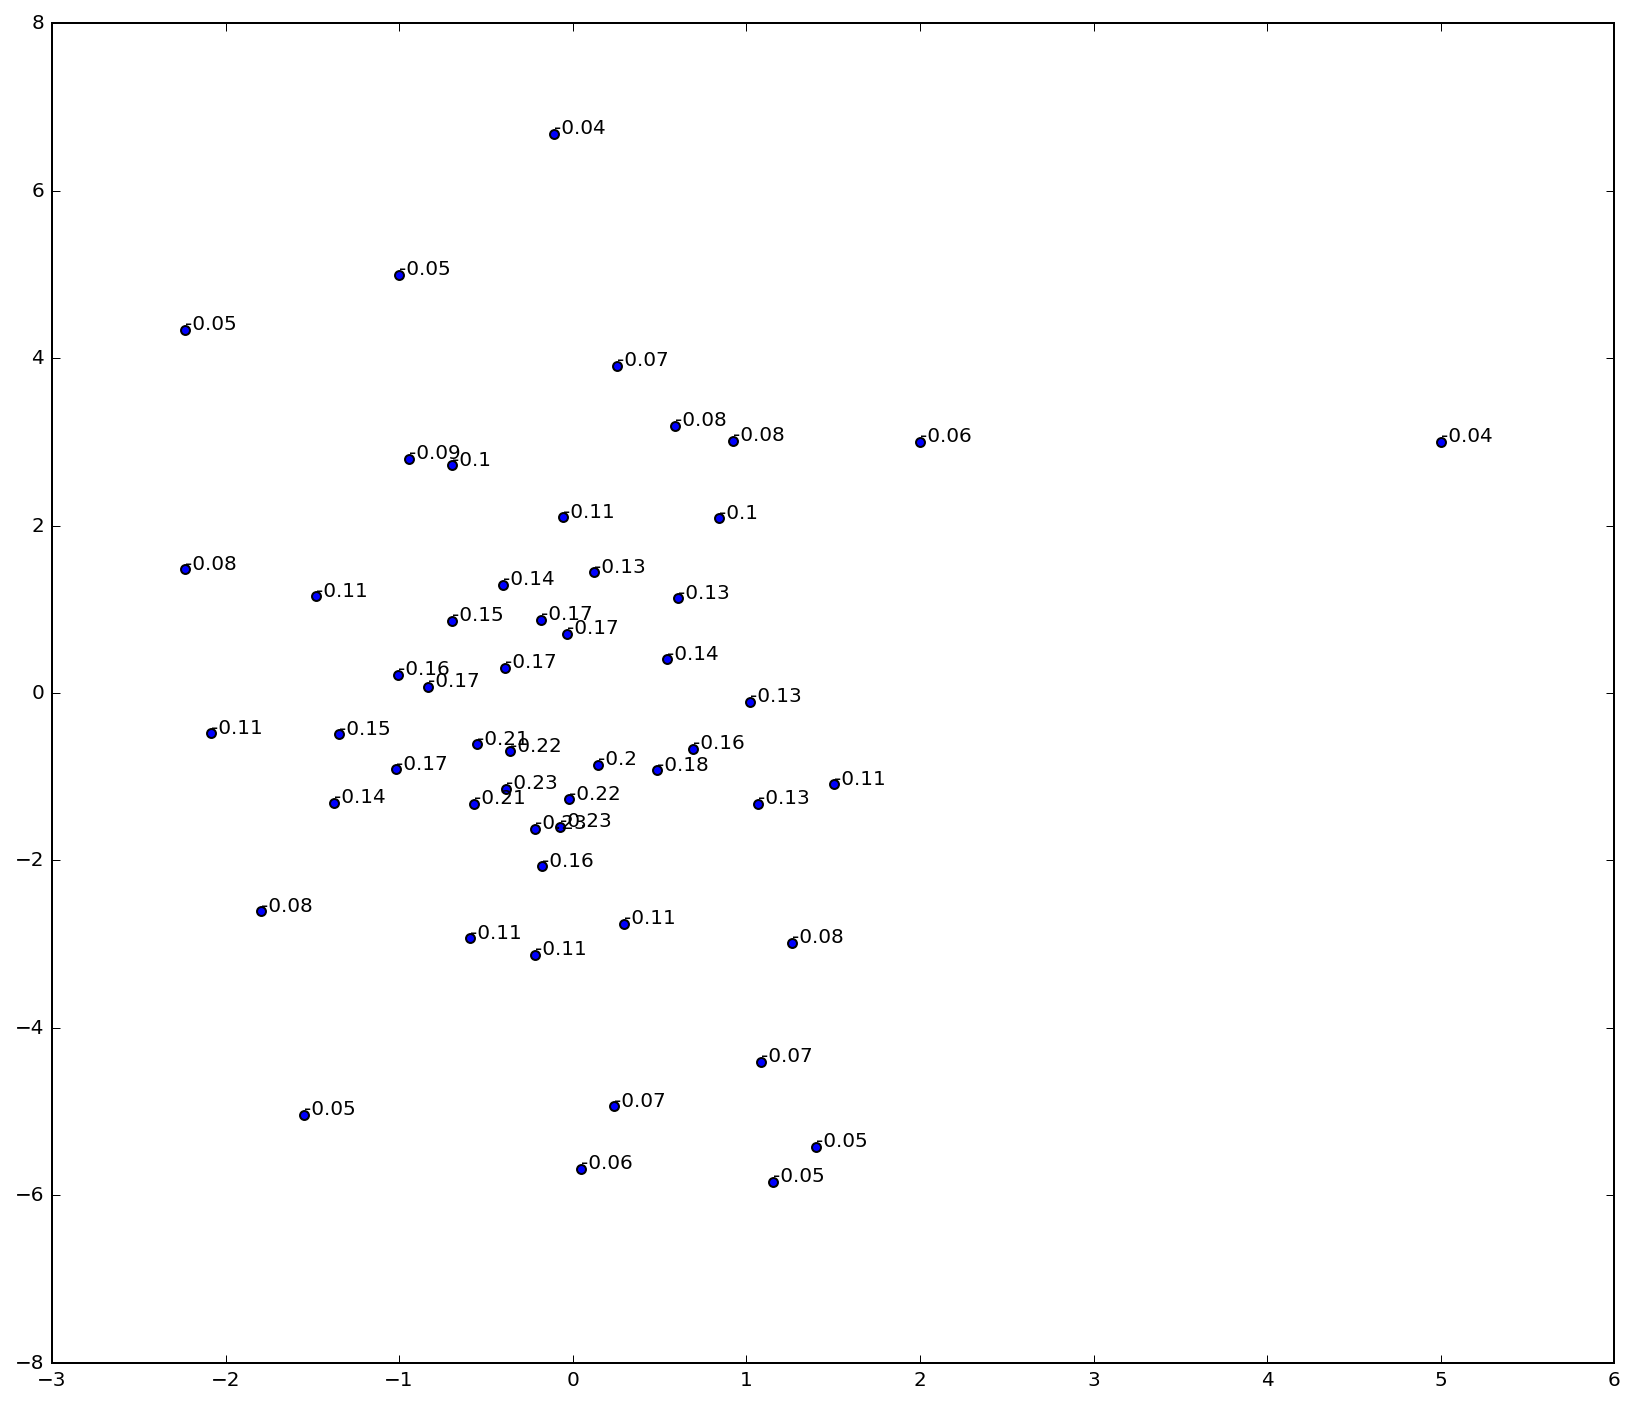

In [36]:
from sklearn.metrics.pairwise import pairwise_distances as dist_matrix
from sklearn.preprocessing import StandardScaler
from scipy.sparse.linalg import eigsh
import math

W = 1 / dist_matrix(X, metric='manhattan', n_jobs = -1)
W[W == np.inf] = 0
W
w, v = eigsh(W, k=1)

fig = plt.figure()
ax = fig.add_subplot(111)

plt.scatter(X[:, 0], X[:, 1])
for i in range(len(X)):
    ax.text(X[i][0], X[i][1], str(round(v[i][0], 2)))

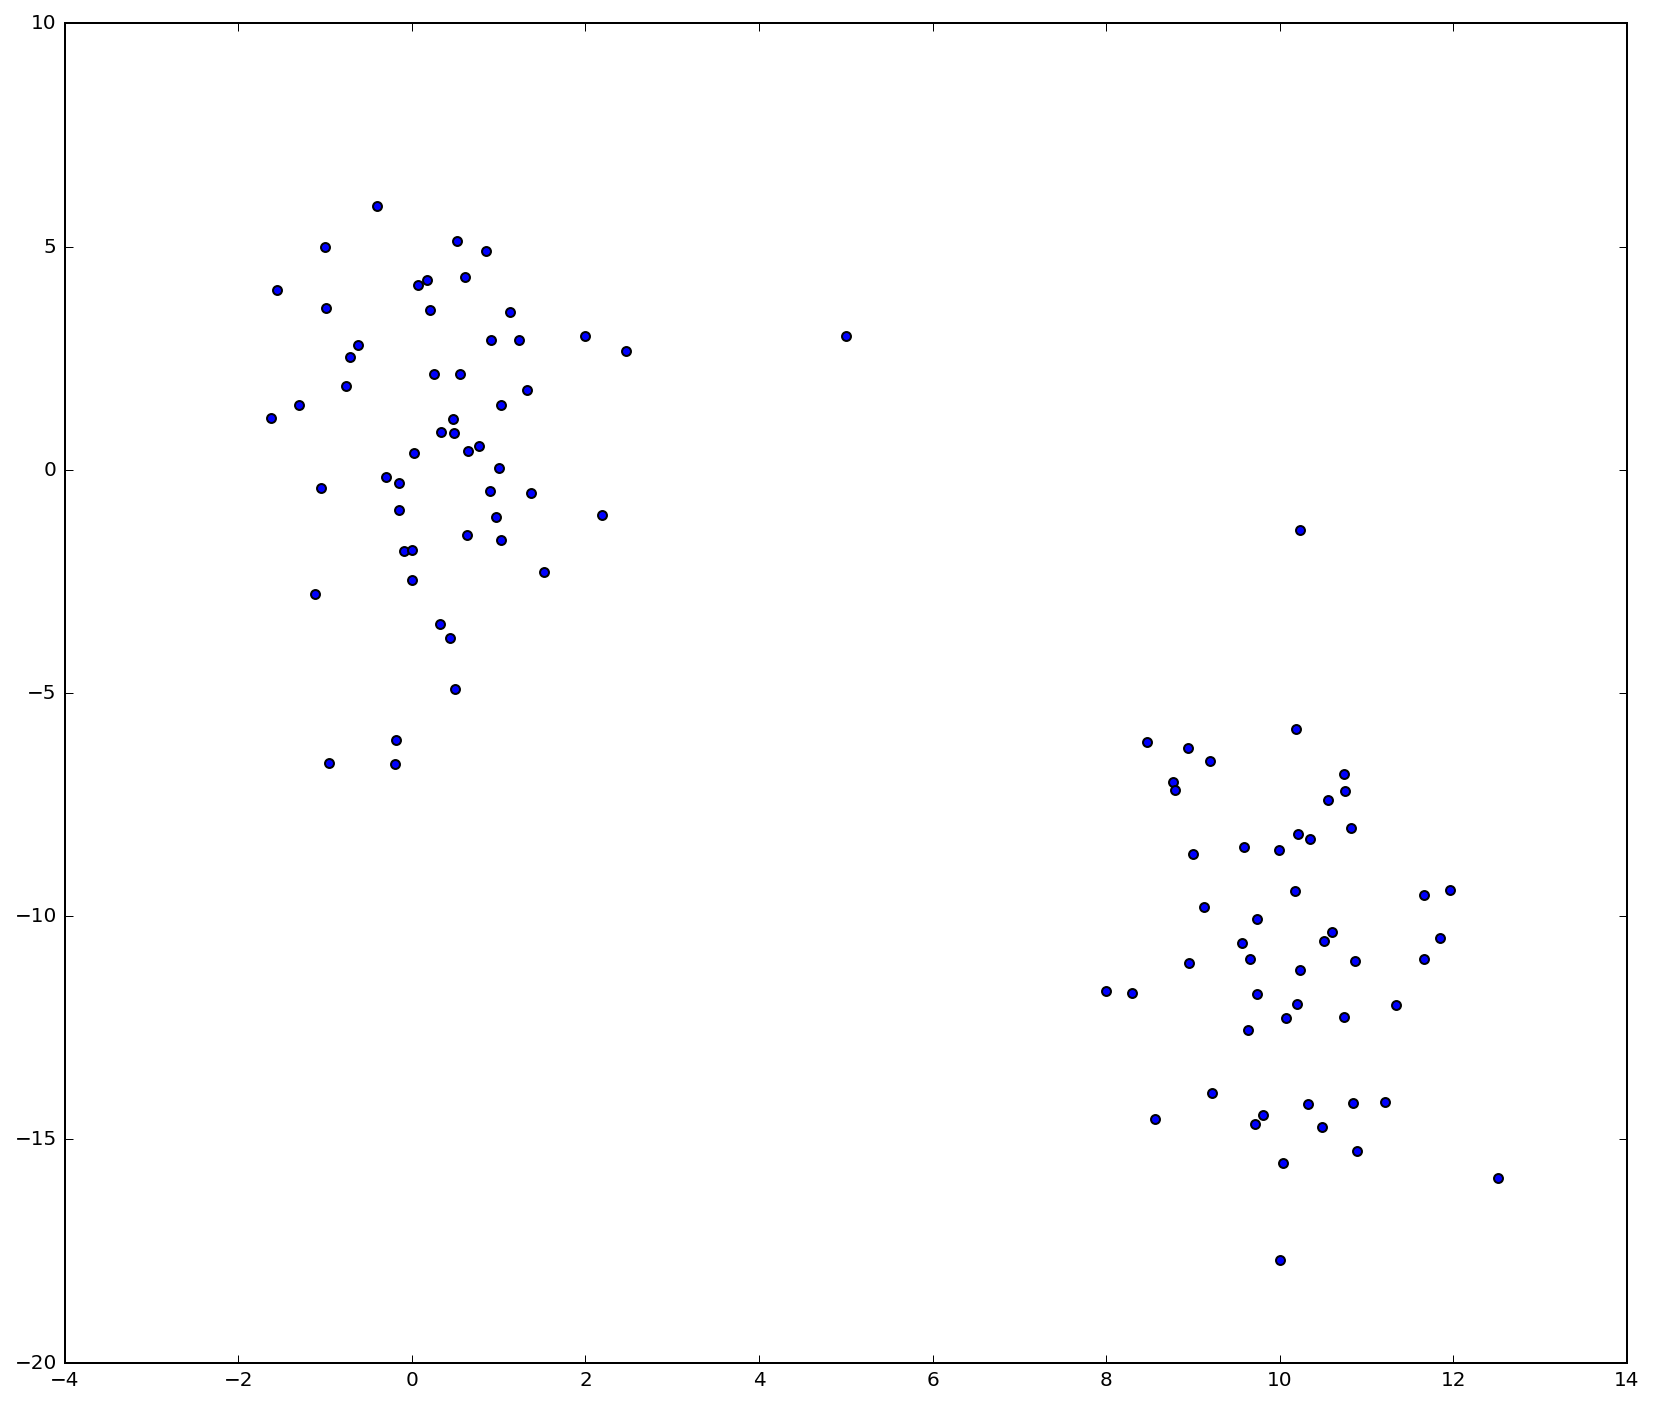

In [41]:
X = np.random.normal(scale=[1, 3], size=(50, 2))
X = np.vstack([X, np.random.normal([10, -10], scale=[1, 3], size=(50, 2)), np.array([[2, 3], [-1, 5], [5, 3]])])
plt.scatter(X[:, 0], X[:, 1])

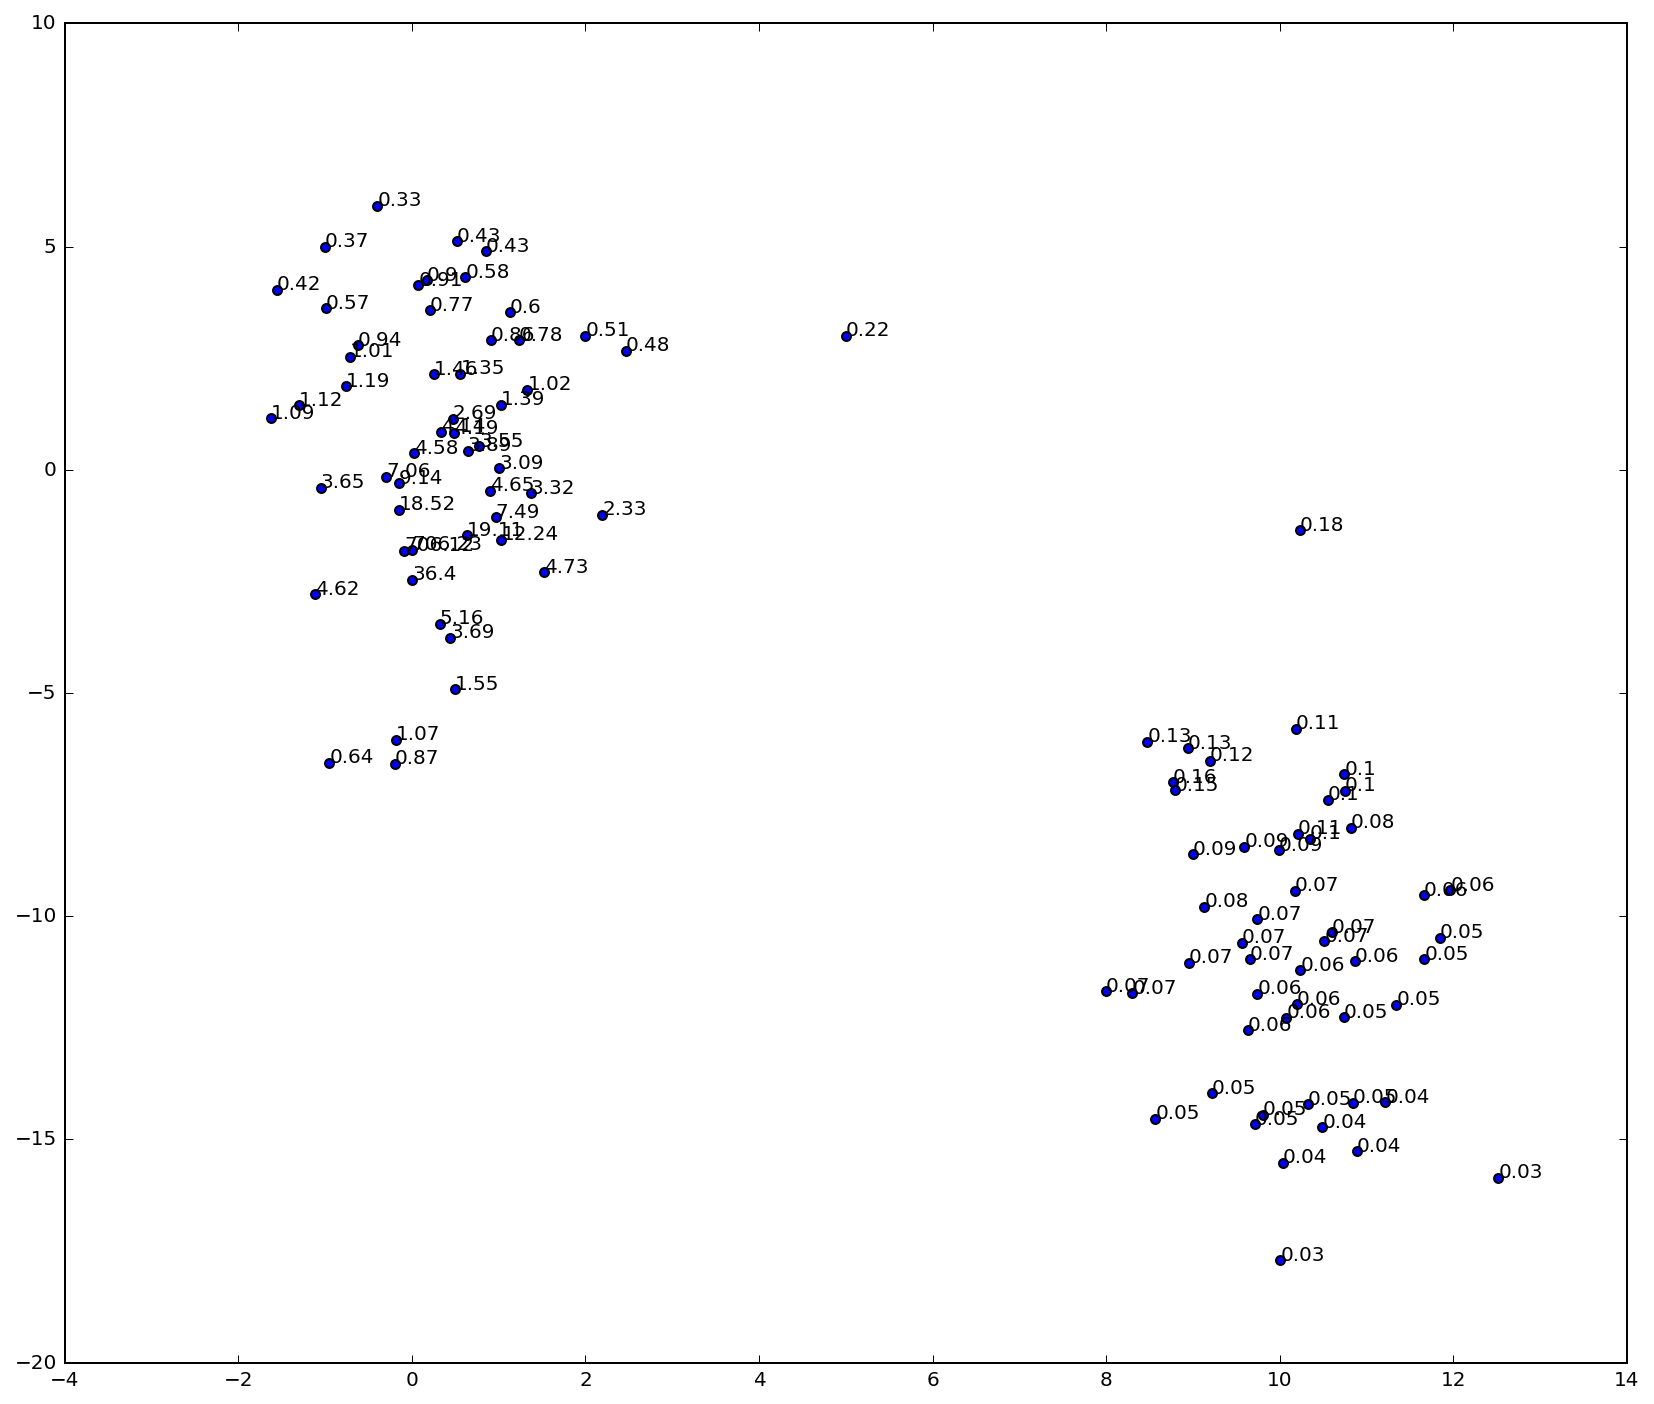

In [46]:
from sklearn.metrics.pairwise import pairwise_distances as dist_matrix
from sklearn.preprocessing import StandardScaler
from scipy.sparse.linalg import eigsh
import math

DM = dist_matrix(X, metric='manhattan', n_jobs = -1)
W = 1 / DM**2
W[W == np.inf] = 0
w, v = eigsh(W, k=1)

fig = plt.figure()
ax = fig.add_subplot(111)

plt.scatter(X[:, 0], X[:, 1])
for i in range(len(X)):
    ax.text(X[i][0], X[i][1], str(round(v[i][0] * 1000, 2)))

In [240]:
class PCSolver:
    def __init__(self):
        pass
    
    def fit(self, X):
        self.scal = StandardScaler().fit(X)
        self.X = self.scal.transform(X)
        return self
        
    def decision_function(self, New_X):
        Unite = np.vstack([self.scal.transform(New_X)])
        DM = dist_matrix(Unite, n_jobs = -1)#, metric='chebyshev')
        print(DM)
        
        W = 1 / DM**2
        W[W == np.inf] = 0
        w, v = eigsh(W, k=1)
        v = v / v.max()
        print(sorted(v))
        #print(v[:, 0])
        #v = v[:, 0]
        
        #a = IsolationForest(n_estimators=1000).fit(v).decision_function(v[len(self.X):])
        
        v =  v[:, 0]
        return v

In [2]:
class PCSolver:
    def __init__(self, metric='chebyshev'):
        self.metric = metric
    
    def fit(self, X):
        self.scal = StandardScaler().fit(X)
        self.X = self.scal.transform(X)
        return self
        
    def decision_function(self, New_X):
        DM = dist_matrix(self.scal.transform(New_X), self.X, n_jobs = -1, metric=self.metric)
        ans = (DM**0.01).prod(axis=1)
        return -ans

In [ ]:
X = [[3], [4], [4], [5], [-1]]
new_X = [[2], [-2], [4.1]]

PCSolver().fit(X).decision_function(new_X)

In [4]:
from sklearn.base import BaseEstimator
import numbers

In [5]:
class MyIsolationTree(BaseEstimator):
    def __init__(self):
        pass

    def fit(self, X):
        def fit_node(subX, n):
            if ((subX - subX[0]) == 0).all():
                return n, subX.shape[0]
            
            disp = np.empty((subX.shape[1]))
            for i in range(subX.shape[1]):
                s = np.sort(subX[:, i])
                differences = s[1:] - s[:-1]
                if differences.sum() != 0:
                    differences /= differences.sum()
                disp[i] = ((differences - differences.mean())**2).mean()**0.5
            
            if disp.sum() != 0:
                disp /= disp.sum()
            else:
                return n, subX.shape[0]
            
            min_limit = max_limit = 0
            while min_limit == max_limit:
                #optimal_feature = np.random.randint(0, subX.shape[1])
                optimal_feature = np.random.choice(range(subX.shape[1]), p=disp)

                min_limit = subX[:, optimal_feature].min()
                max_limit = subX[:, optimal_feature].max()
            
            optimal_threshold = np.random.uniform() * (max_limit - min_limit) + min_limit
            
            return (optimal_feature, optimal_threshold,
                   fit_node(subX[subX[:, optimal_feature] < optimal_threshold], n + 1),
                   fit_node(subX[subX[:, optimal_feature] >= optimal_threshold], n + 1))
        
        self.node = fit_node(X, 0)
        
    def predict(self, X, with_leaf_node=False):
        def predict_node(x, node):
            if len(node) == 2:
                if with_leaf_node:
                    return node[0], node[1]
                return node[0]
            
            if x[node[0]] < node[1]:
                return predict_node(x, node[2])
            else:
                return predict_node(x, node[3])
        
        if with_leaf_node:
            return zip(*np.array([predict_node(X[i], self.node) for i in range(len(X))]))
        return np.array([predict_node(X[i], self.node) for i in range(len(X))])

In [6]:
class MyIsolationForest(BaseEstimator):
    def __init__(self, n_estimators=100):
        self.n_estimators = n_estimators
        
        self.trees = []
        for i in range(n_estimators):
            self.trees.append(MyIsolationTree())

    def fit(self, X):
        for tree in self.trees:
            tree.fit(X)
            #print('|')
        self.max_samples_ = X.shape[0]
        
    def decision_function(self, X):
        #X = self.estimators_[0]._validate_X_predict(X, check_input=True)
        n_samples = X.shape[0]
        n_samples_leaf = np.zeros((n_samples, self.n_estimators), order="f")
        depths = np.zeros((n_samples, self.n_estimators), order="f")

        for i, tree in enumerate(self.trees):
            depths[:, i], n_samples_leaf[:, i] = tree.predict(X, True)
        
        depths += _average_path_length(n_samples_leaf)

        scores = 2 ** (-depths.mean(axis=1) / _average_path_length(self.max_samples_))

        # Take the opposite of the scores as bigger is better (here less
        # abnormal) and add 0.5 (this value plays a special role as described
        # in the original paper) to give a sense to scores = 0:
        return 0.5 - scores

# стащено из скайлёрна
def _average_path_length(n_samples_leaf):
    """ The average path length in a n_samples iTree, which is equal to
    the average path length of an unsuccessful BST search since the
    latter has the same structure as an isolation tree.
    Parameters
    ----------
    n_samples_leaf : array-like of shape (n_samples, n_estimators), or int.
        The number of training samples in each test sample leaf, for
        each estimators.

    Returns
    -------
    average_path_length : array, same shape as n_samples_leaf
    """
    INTEGER_TYPES = (numbers.Integral, np.integer)
    if isinstance(n_samples_leaf, INTEGER_TYPES):
        if n_samples_leaf <= 1:
            return 1.
        else:
            return 2. * (np.log(n_samples_leaf) + 0.5772156649) - 2. * (
                n_samples_leaf - 1.) / n_samples_leaf

    else:
        n_samples_leaf_shape = n_samples_leaf.shape
        n_samples_leaf = n_samples_leaf.reshape((1, -1))
        average_path_length = np.zeros(n_samples_leaf.shape)

        mask = (n_samples_leaf <= 1)
        not_mask = np.logical_not(mask)

        average_path_length[mask] = 1.
        average_path_length[not_mask] = 2. * (
            np.log(n_samples_leaf[not_mask]) + 0.5772156649) - 2. * (
                n_samples_leaf[not_mask] - 1.) / n_samples_leaf[not_mask]

        return average_path_length.reshape(n_samples_leaf_shape)   

# PIMA

In [7]:
DF = pd.read_csv("pima.csv", sep=',', header=None)
ans = (DF[8] == 1)[576:]
del DF[8]

DF, DF_test = DF[:576], DF[576:]
DF

,0,1,2,3,4,5,6,7
0,6,148,72,35,0,33.6,0.627,50
1,1,85,66,29,0,26.6,0.351,31
2,8,183,64,0,0,23.3,0.672,32
3,1,89,66,23,94,28.1,0.167,21
4,0,137,40,35,168,43.1,2.288,33
5,5,116,74,0,0,25.6,0.201,30
6,3,78,50,32,88,31.0,0.248,26
7,10,115,0,0,0,35.3,0.134,29
8,2,197,70,45,543,30.5,0.158,53
9,8,125,96,0,0,0.0,0.232,54


AUC-ROC score:  0.721194379391


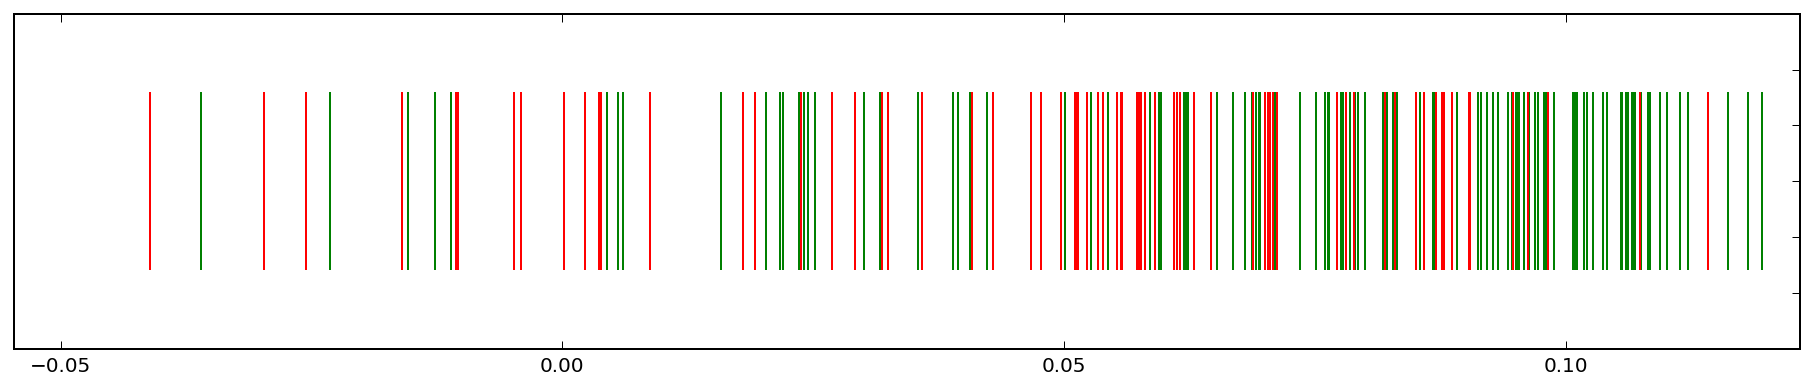

In [8]:
normaly_score, anomaly_score = exp.Solve(IsolationForest(1000), DF, DF_test[~ans], DF_test[ans])

AUC-ROC score:  0.703161592506


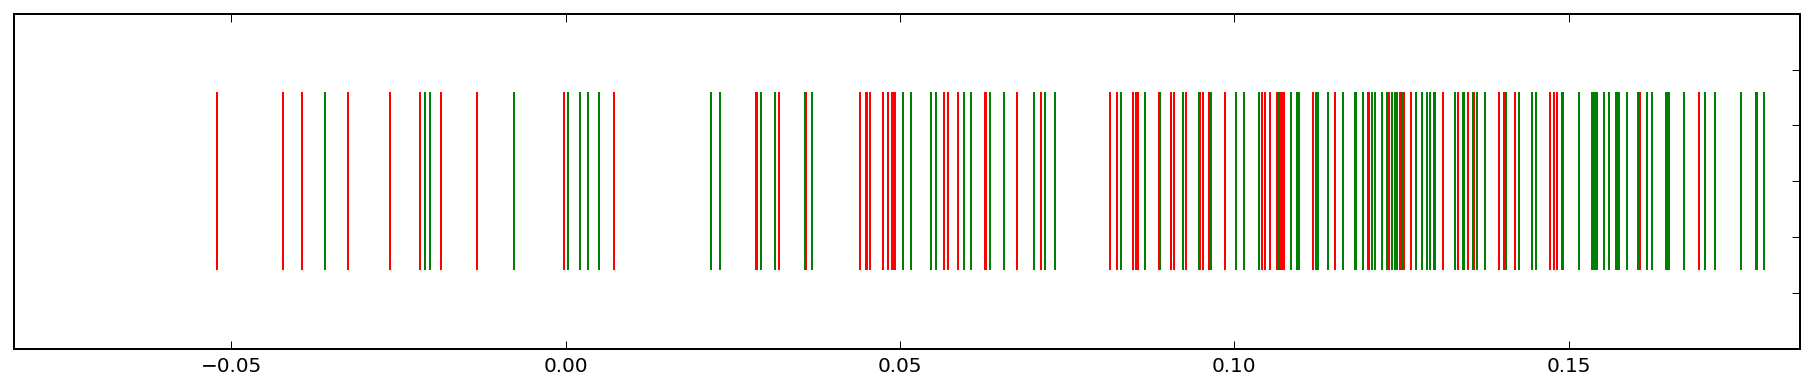

In [9]:
normaly_score, anomaly_score = exp.Solve(MyIsolationForest(100), DF.as_matrix(), DF_test[~ans].as_matrix(), DF_test[ans].as_matrix())

AUC-ROC score:  0.652576112412


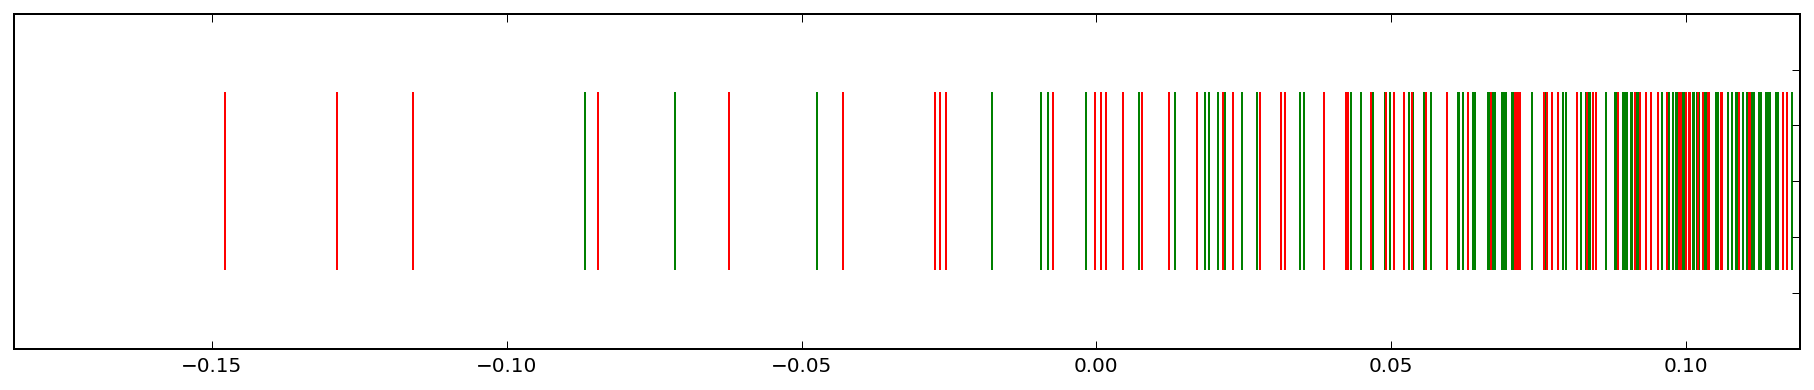

In [70]:
normaly_score, anomaly_score = exp.Solve(exp.modIsolationForest(1000), DF, DF_test[~ans], DF_test[ans])

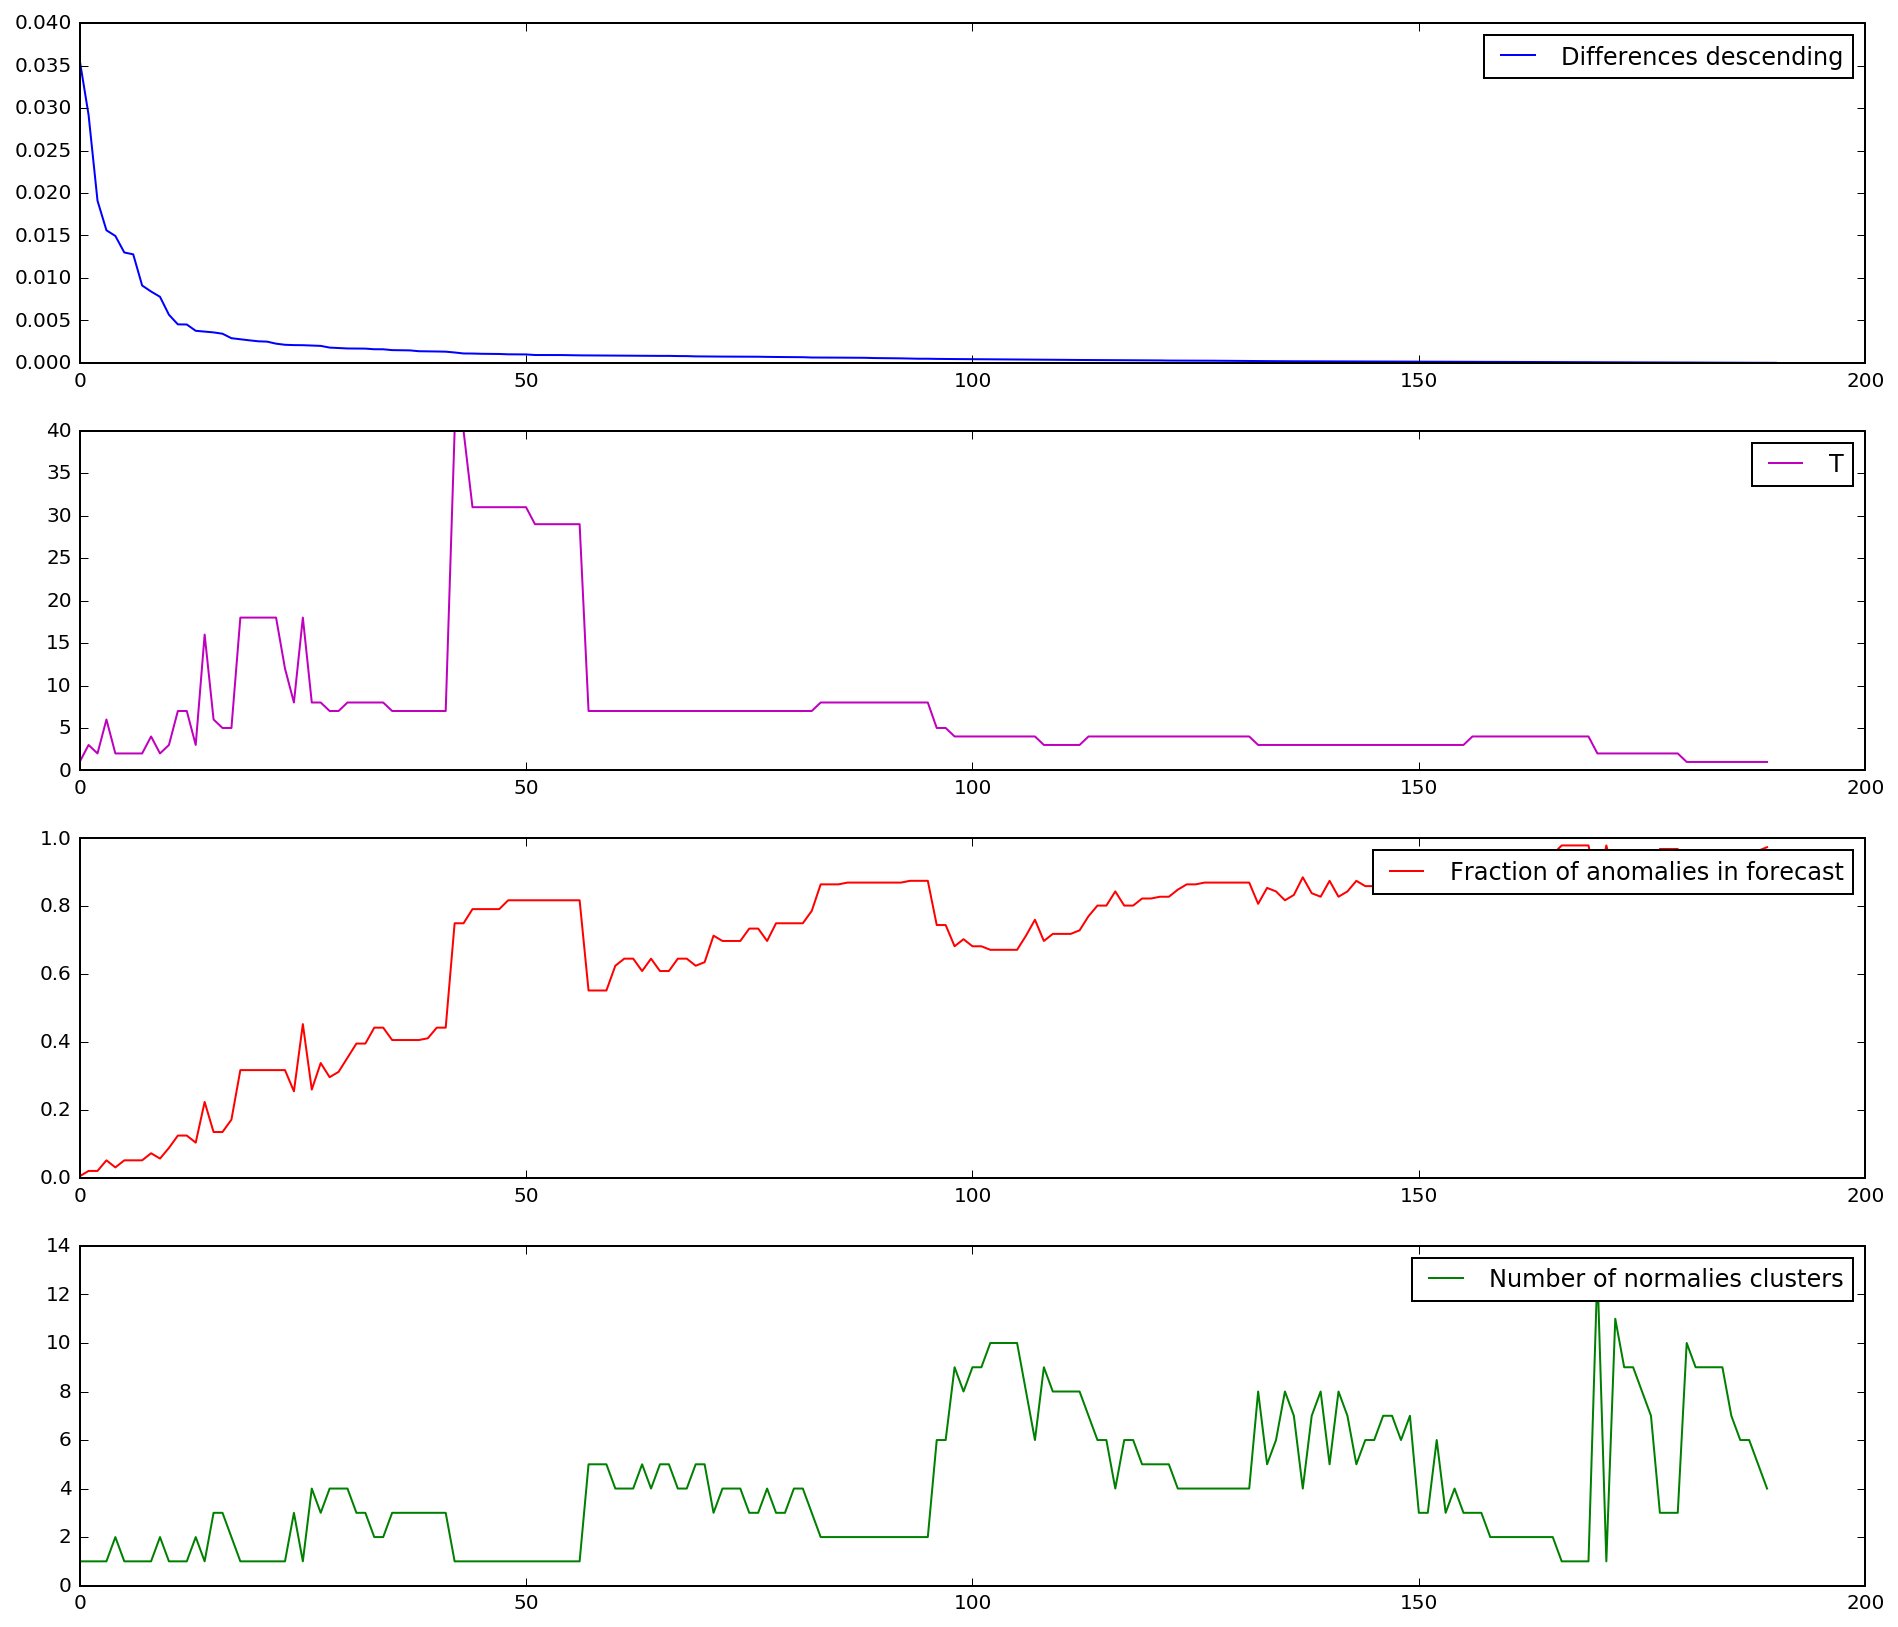

In [72]:
exp.analize_threshold(normaly_score, anomaly_score, -1)

In [73]:
exp.submit_variants(normaly_score, anomaly_score, 0.5)

variant: n_splits= 4 T =  6 , anom_frac =  0.0520833333333
variant: n_splits= 9 T =  4 , anom_frac =  0.0729166666667
variant: n_splits= 13 T =  7 , anom_frac =  0.125
variant: n_splits= 15 T =  16 , anom_frac =  0.223958333333
variant: n_splits= 24 T =  12 , anom_frac =  0.317708333333
variant: n_splits= 26 T =  18 , anom_frac =  0.453125


T =  18
Anomalies Fraction =  0.453125 %


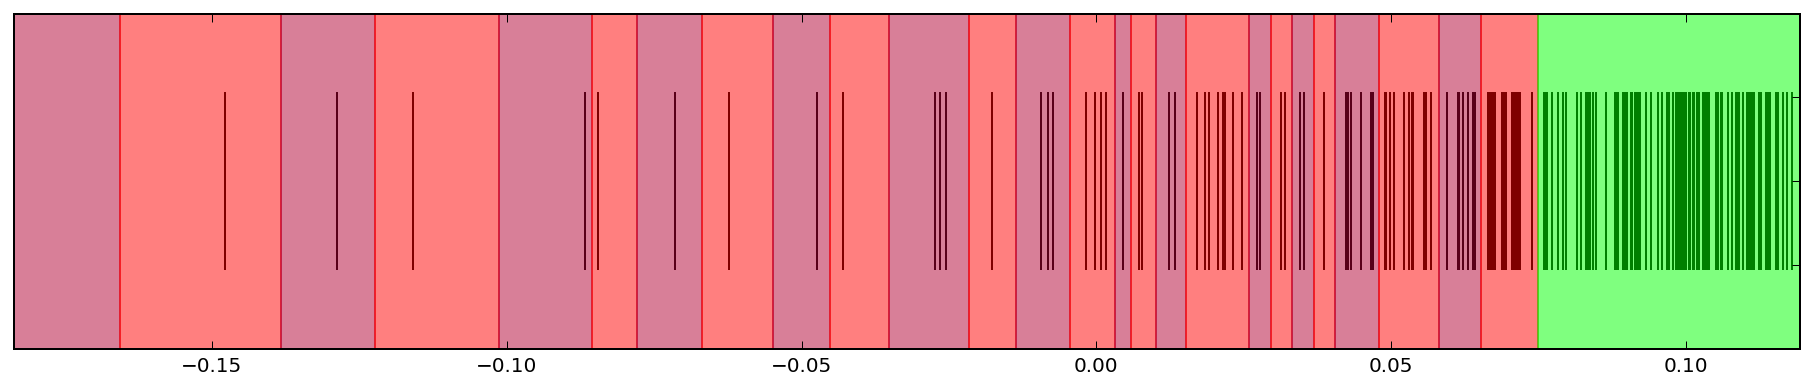

In [74]:
f = exp.apply_threshold(normaly_score, anomaly_score, 26)

In [75]:
exp.f_measure(np.append(np.zeros_like(normaly_score), np.ones_like(anomaly_score)), f)

precision =  0.448275862069
recall =  0.557142857143
f-measure =  0.496815286624


0.49681528662420382

Теперь сколько потенциально можно было выжать:

Potential max f-measure =  0.575221238938  (thr =  0.106091193353 )


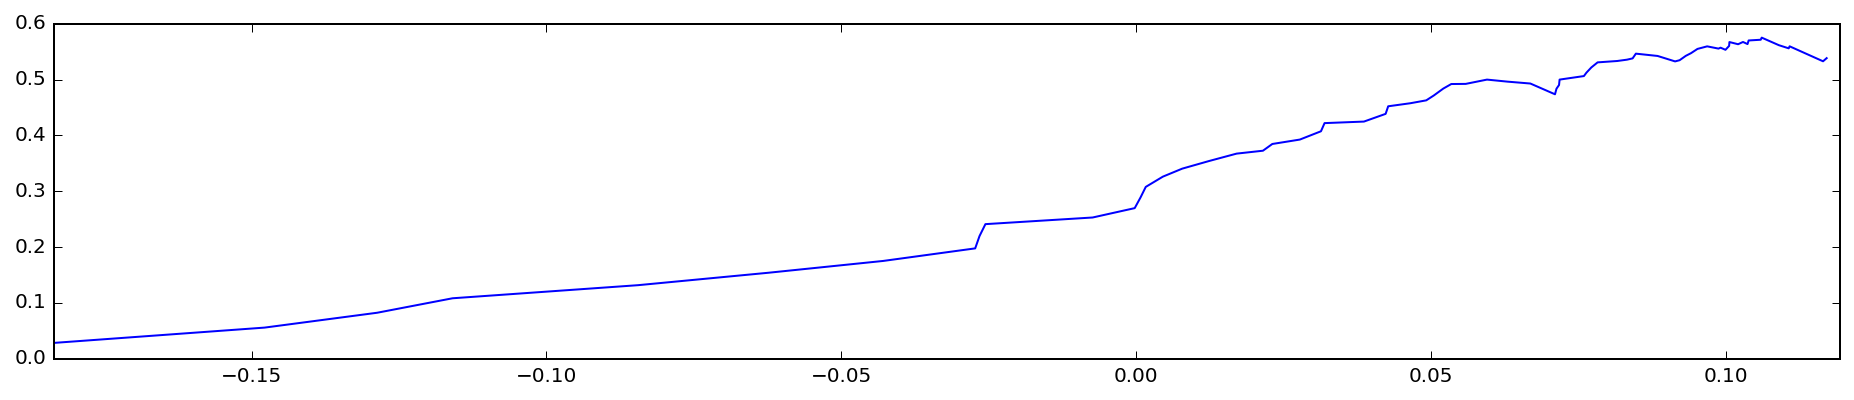

In [76]:
exp.potential_f_measure(normaly_score, anomaly_score)

То есть для хорошей F-меры тут надо было fraction of anomalies in forecast аж выше 0.5 делать... интересно-интересно.

# SATTELITE

Вот, дивный датасет! Космические снимки! Со спутника!
Датасет, по заявкам, небольшой кусок картинки космического снимка. Для каждого пикселя даны значения 4 каналов (два инфракрасных канала, зелёный спектр, красный спектр) для него и для 8 его соседей. Всё перемешано и что-то убрано, чтобы нельзя было восстановить оригинальное изображение. Требуется определить, что сфотографировано "в этом пикселе".

In [235]:
DF = pd.read_csv("satellite.csv", sep=';', header=None)
del DF[36]
DF

DF_test = pd.read_csv("satellite_test.csv", sep=';', header=None)
ans = (DF_test[36] == 2) | (DF_test[36] == 4) | (DF_test[36] == 5)
del DF_test[36]

In [236]:
DF

,0,1,2,3,4,5,6,7,8,9,...,26,27,28,29,30,31,32,33,34,35
0,92,115,120,94,84,102,106,79,84,102,...,134,104,88,121,128,100,84,107,113,87
1,84,102,106,79,84,102,102,83,80,102,...,128,100,84,107,113,87,84,99,104,79
2,84,102,102,83,80,102,102,79,84,94,...,113,87,84,99,104,79,84,99,104,79
3,80,102,102,79,84,94,102,79,80,94,...,104,79,84,99,104,79,84,103,104,79
4,84,94,102,79,80,94,98,76,80,102,...,104,79,84,103,104,79,79,107,109,87
5,80,94,98,76,80,102,102,79,76,102,...,104,79,79,107,109,87,79,107,109,87
6,76,102,106,83,76,102,106,87,80,98,...,113,87,79,103,104,83,79,103,104,79
7,76,102,106,87,80,98,106,79,76,94,...,104,83,79,103,104,79,79,95,100,79
8,76,89,98,76,76,94,98,76,76,98,...,96,75,75,91,96,71,79,87,93,71
9,76,94,98,76,76,98,102,72,76,94,...,96,71,79,87,93,71,79,87,93,67


In [241]:
normaly_score, anomaly_score = exp.Solve(PCSolver(), DF, DF_test[~ans], DF_test[ans])

[[  0.00000000e+00   3.11550024e+00   4.55223706e+00 ...,   6.81739038e+00
    6.51428672e+00   6.61528913e+00]
 [  3.11550024e+00   0.00000000e+00   2.02782923e+00 ...,   4.81070396e+00
    4.29867086e+00   4.21275694e+00]
 [  4.55223706e+00   2.02782923e+00   5.96046448e-08 ...,   3.96648264e+00
    3.31816827e+00   3.18640634e+00]
 ..., 
 [  6.81739038e+00   4.81070396e+00   3.96648264e+00 ...,   0.00000000e+00
    1.81112632e+00   2.29984551e+00]
 [  6.51428672e+00   4.29867086e+00   3.31816827e+00 ...,   1.81112632e+00
    2.98023224e-08   1.64417417e+00]
 [  6.61528913e+00   4.21275694e+00   3.18640634e+00 ...,   2.29984551e+00
    1.64417417e+00   2.98023224e-08]]
[array([-1.02899984]), array([-0.82199114]), array([-0.46977063]), array([-0.02629334]), array([ -2.76945454e-16]), array([ -2.29132205e-16]), array([ -2.29049696e-16]), array([ -2.27492293e-16]), array([ -2.19806917e-16]), array([ -2.15305114e-16]), array([ -2.08891175e-16]), array([ -2.07951976e-16]), array([ -1.9723

ArpackNoConvergence: ARPACK error -1: No convergence (6721 iterations, 0/1 eigenvectors converged)

AUC-ROC score:  0.697358630952


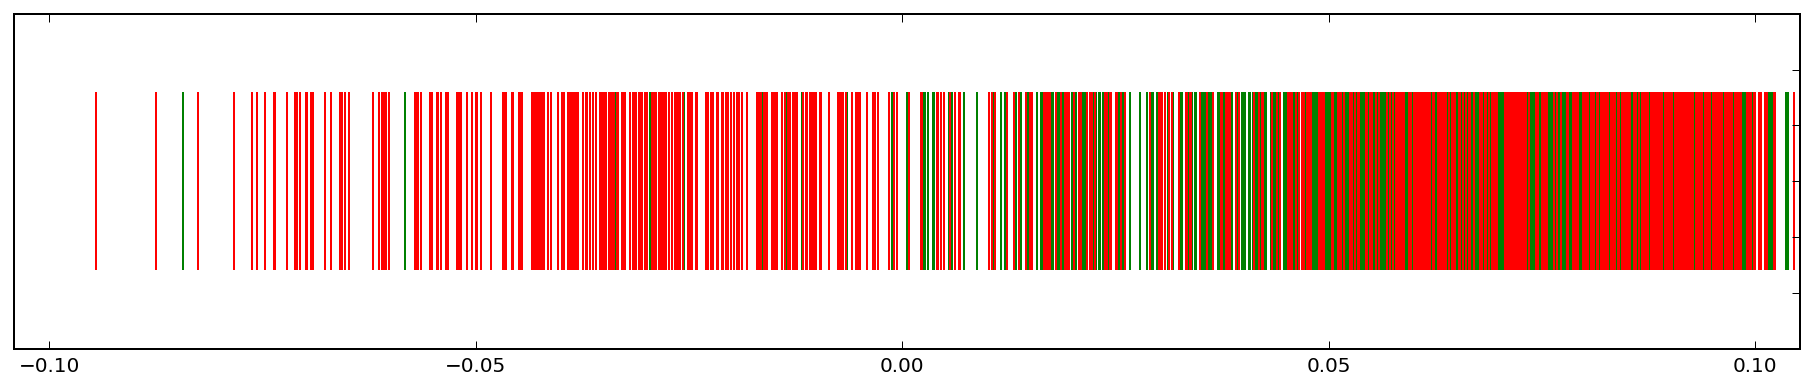

In [5]:
normaly_score, anomaly_score = exp.Solve(IsolationForest(1000), DF, DF_test[~ans], DF_test[ans])

AUC-ROC score:  0.69964007817


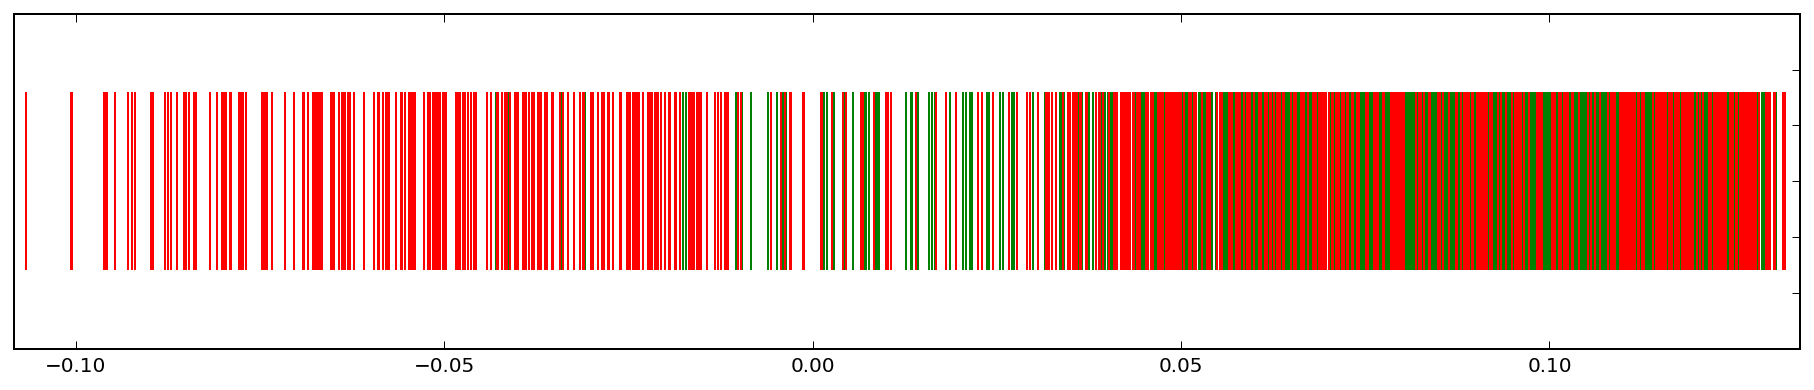

In [6]:
normaly_score, anomaly_score = exp.Solve(exp.modIsolationForest(1000), DF, DF_test[~ans], DF_test[ans])

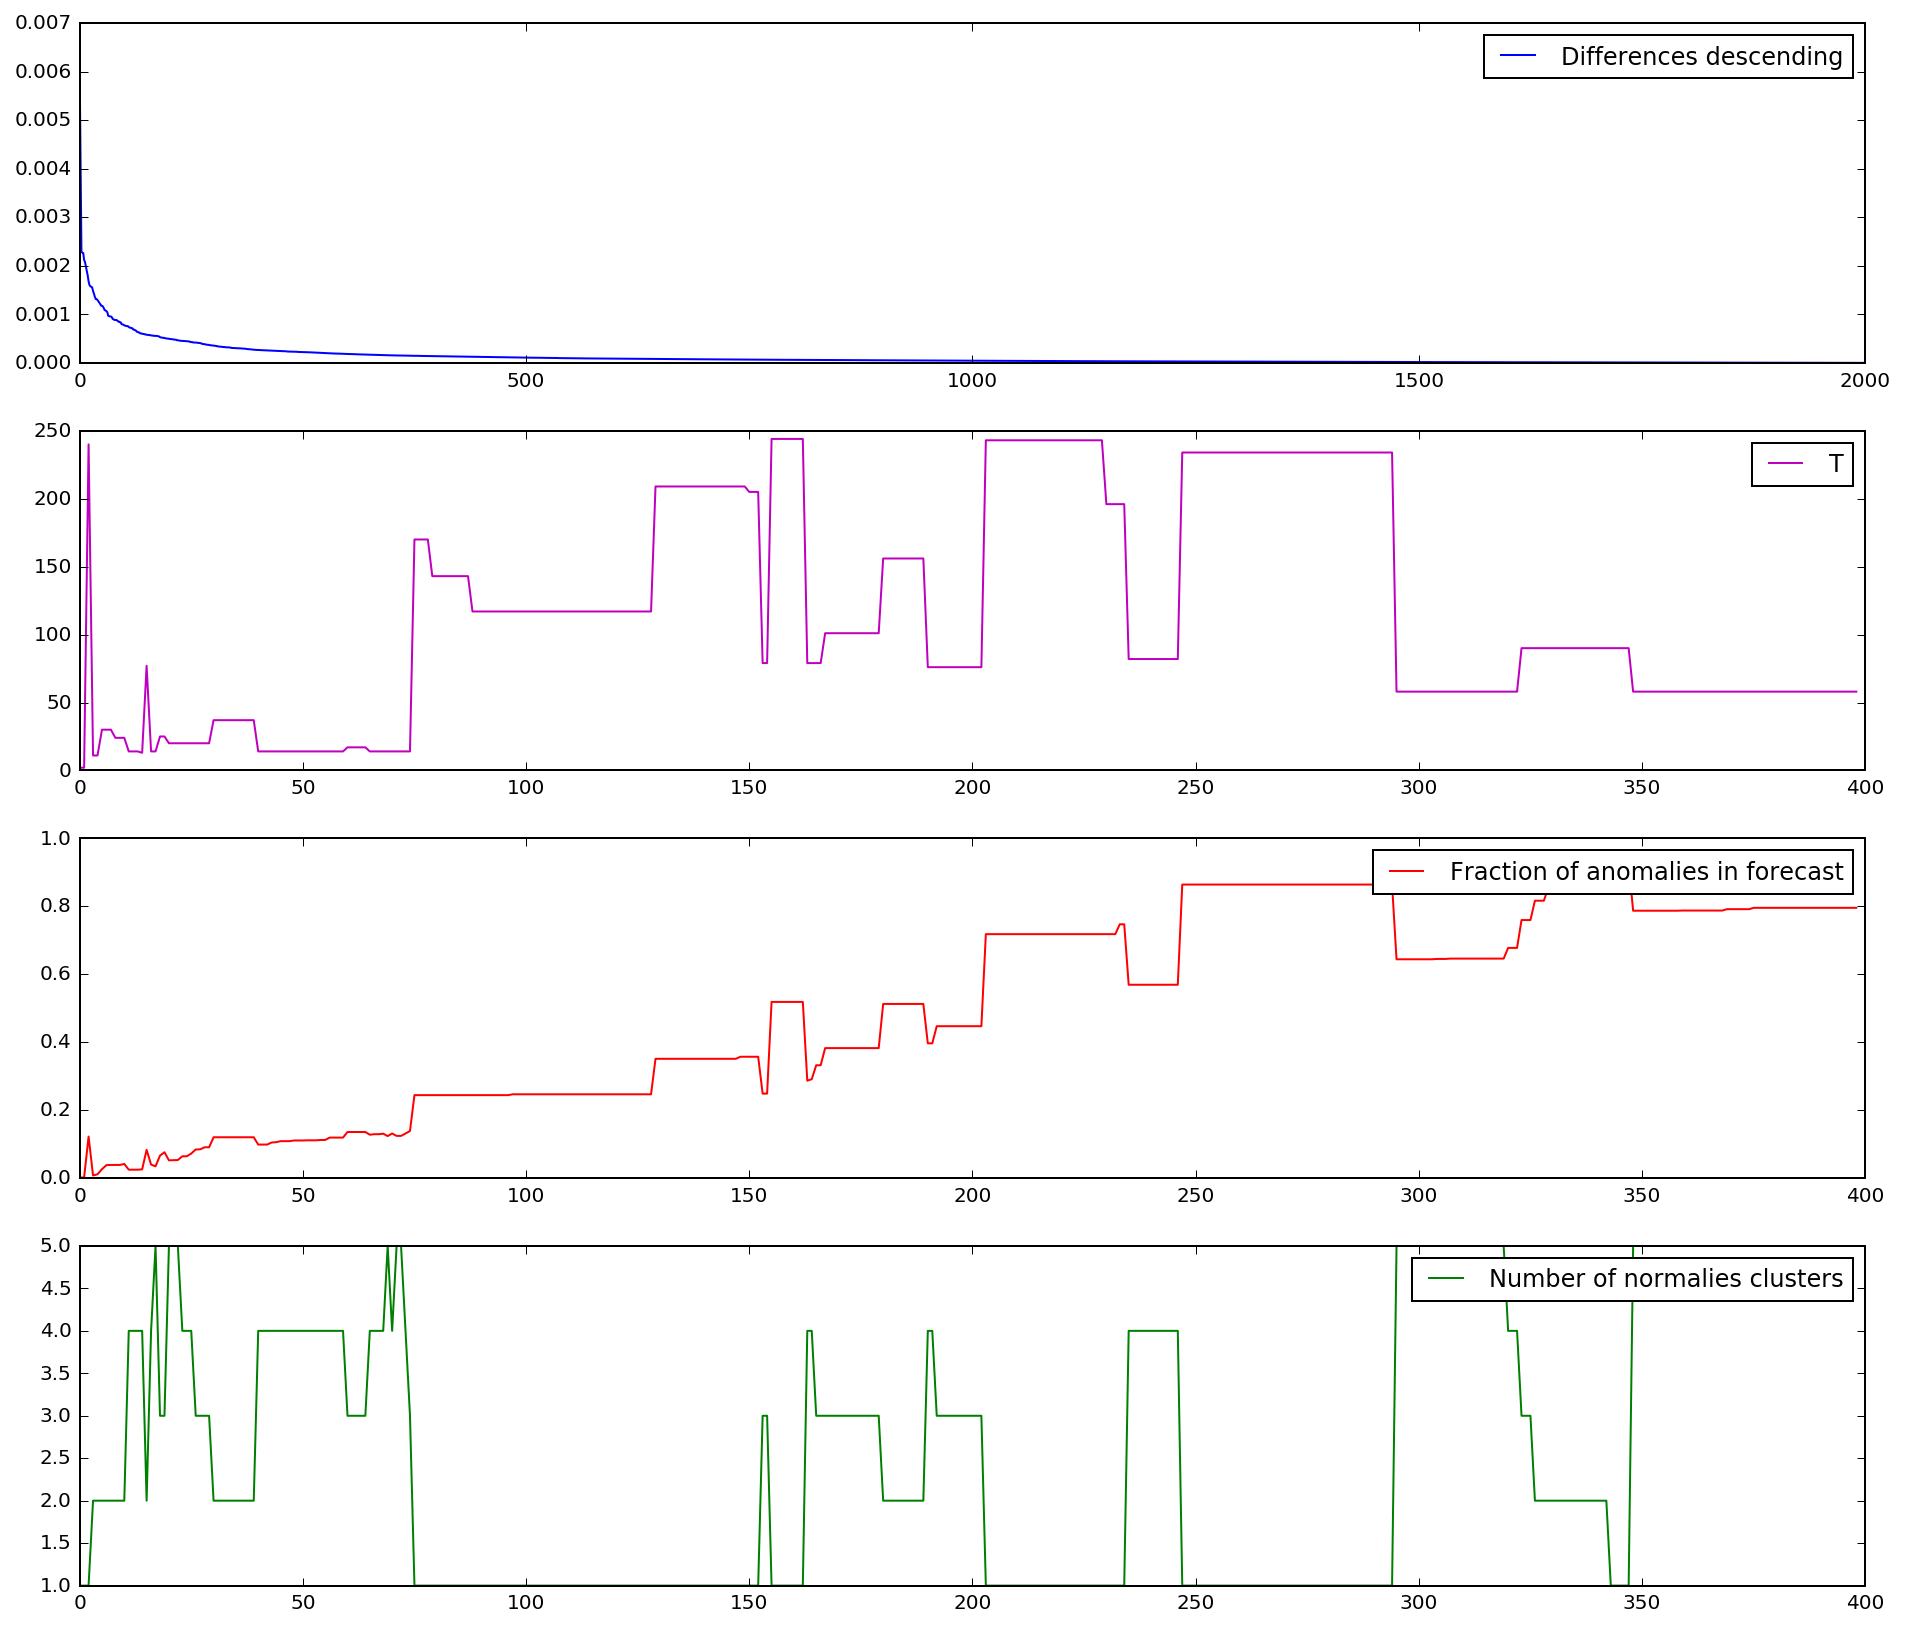

In [7]:
exp.analize_threshold(normaly_score, anomaly_score, 400)

Известно, что Number of normalies clusters на самом деле желательно 1, anomaly_fraction ~ 0.33333.

In [8]:
exp.submit_variants(normaly_score, anomaly_score, 0.5)

variant: n_splits= 3 T =  240 , anom_frac =  0.122
variant: n_splits= 153 T =  205 , anom_frac =  0.357


T =  205
Anomalies Fraction =  0.357 %


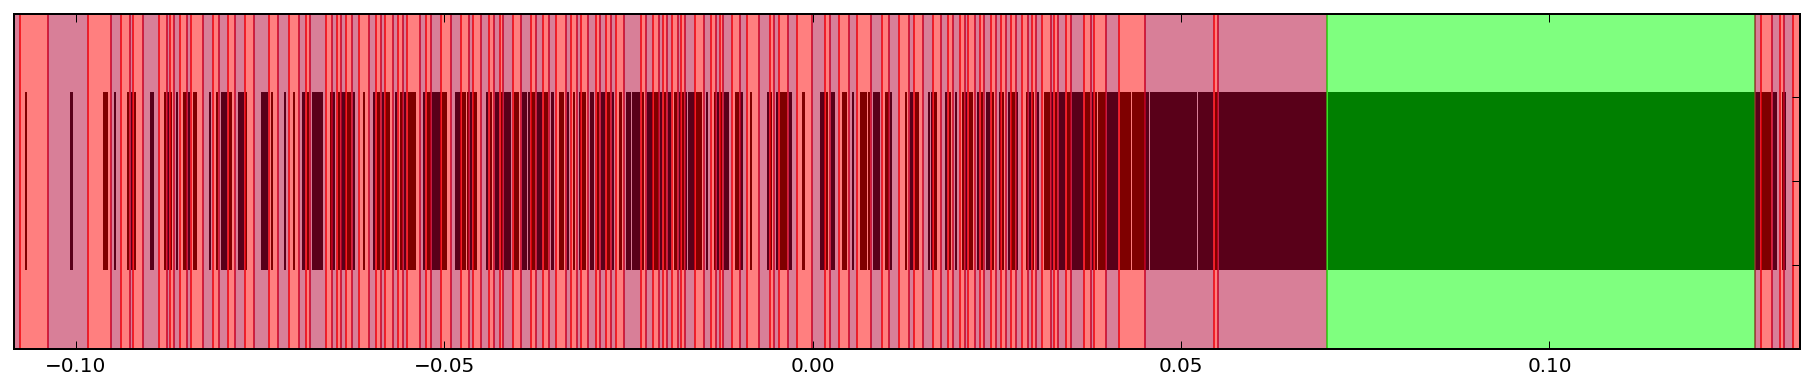

In [12]:
f = exp.apply_threshold(normaly_score, anomaly_score, 153)

In [13]:
exp.f_measure(np.append(np.zeros_like(normaly_score), np.ones_like(anomaly_score)), f)

precision =  0.59243697479
recall =  0.629464285714
f-measure =  0.61038961039


0.61038961038961037

Теперь сколько потенциально можно было выжать:

Potential max f-measure =  0.607468879668  (thr =  0.0579205915197 )


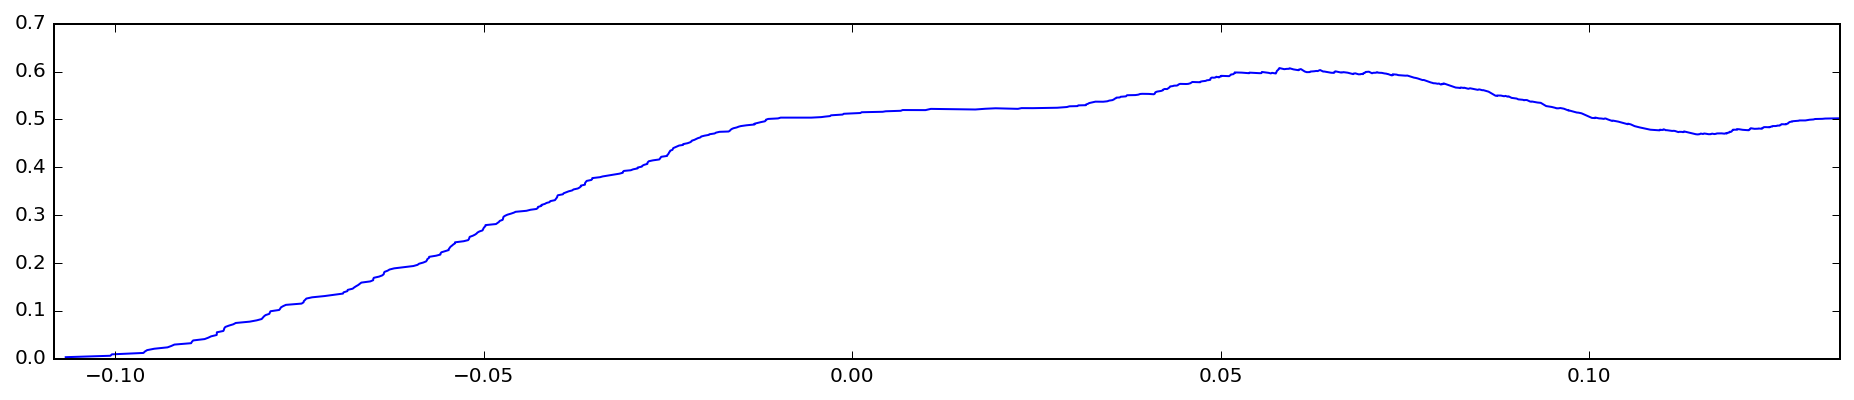

In [14]:
exp.potential_f_measure(normaly_score, anomaly_score)

о_О, точки с высоким anomaly_score что ли на самом деле аномалии? как это так вообще?

# THYROID

и опять...
по этой болезни датасетов в базе много и они намешаны, для аномалий использовался, похоже что, именно эта версия датасета. На теневой столько же объектов, сколько и на обучающей; нет пропущенных значений, которые в прошлых маленьких датасетишках я костыльно забивал -1.

Кстати. Интересный момент. В оригинальном датасете есть ещё 15 бинарных признаков. Если их оставить, лес выдаёт результат около 0.6, когда же без них - около 0.8. Действительно, логично - лесу не нравятся бинарные признаки...

In [243]:
DF = pd.read_csv("ann-train.csv", sep=' ', header=None)
del DF[22]
del DF[23]
del DF[21]

DF_test = pd.read_csv("ann-test.csv", sep=' ', header=None)
ans = (DF_test[21] == 1) | (DF_test[21] == 2)
del DF_test[21]
del DF_test[22]
del DF_test[23]
DF

,0,1,2,3,4,5,6,7,8,9,...,11,12,13,14,15,16,17,18,19,20
0,0.73,0,1,0,0,0,0,0,1,0,...,0,0,0,0,0,0.00060,0.0150,0.120,0.082,0.146
1,0.24,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0.00025,0.0300,0.143,0.133,0.108
2,0.47,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0.00190,0.0240,0.102,0.131,0.078
3,0.64,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0.00090,0.0170,0.077,0.090,0.085
4,0.23,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0.00025,0.0260,0.139,0.090,0.153
5,0.69,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0.00025,0.0160,0.086,0.070,0.123
6,0.85,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0.00025,0.0230,0.128,0.104,0.121
7,0.48,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0.00208,0.0200,0.086,0.078,0.110
8,0.67,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0.00130,0.0240,0.087,0.109,0.080
9,0.76,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0.00010,0.0290,0.124,0.128,0.097


AUC-ROC score:  0.498343612335


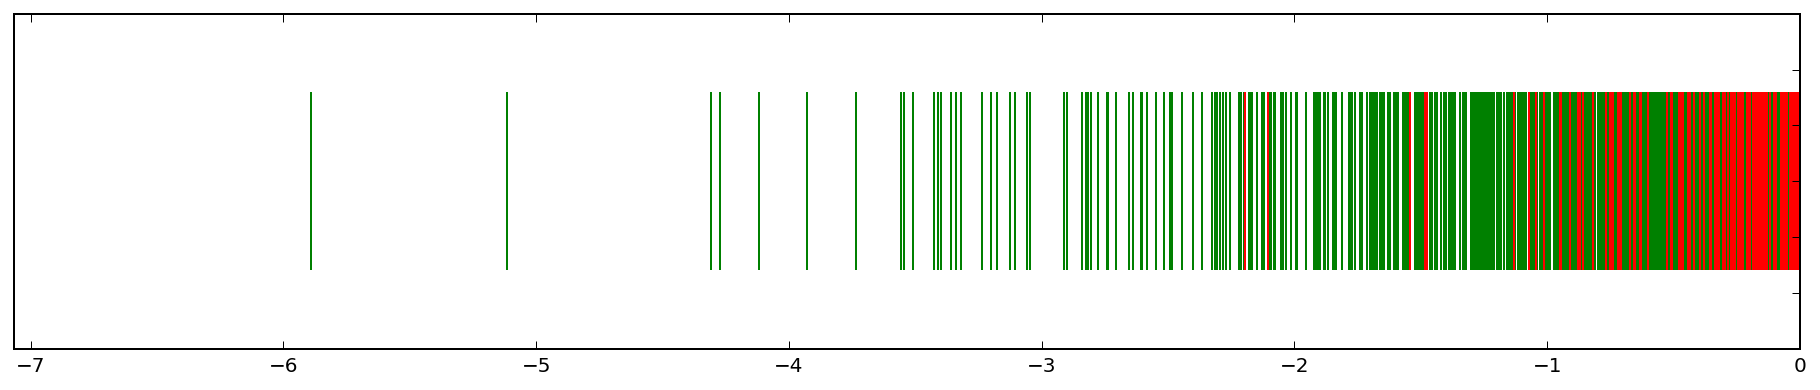

In [248]:
normaly_score, anomaly_score = exp.Solve(PCSolver('cosine'), DF, DF_test[~ans], DF_test[ans])

AUC-ROC score:  0.598996853367


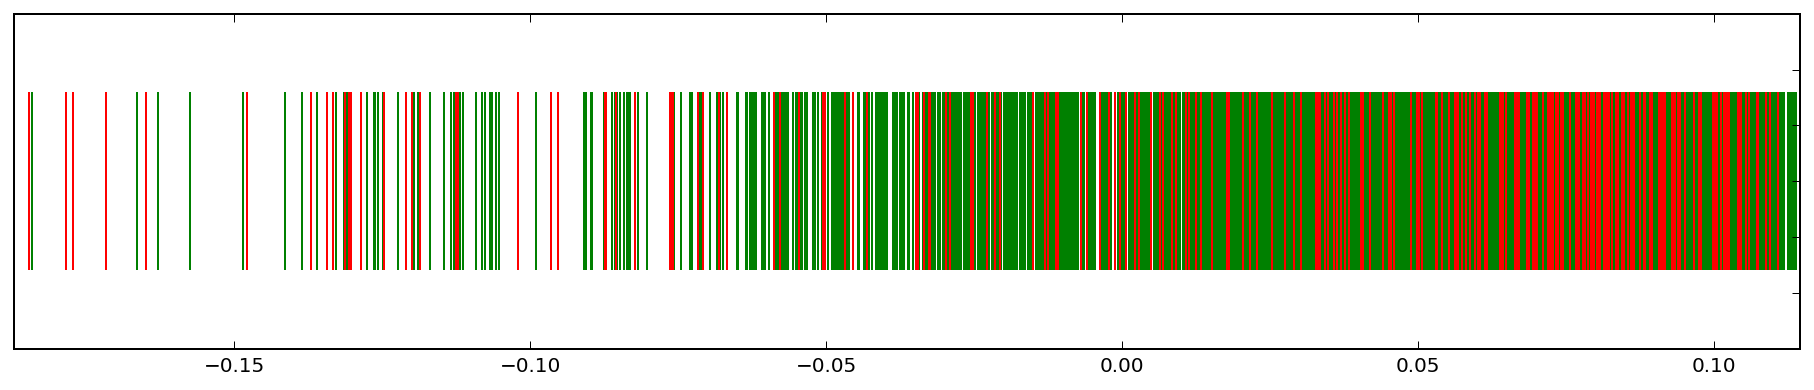

In [116]:
normaly_score, anomaly_score = exp.Solve(exp.modIsolationForest(1000), DF, DF_test[~ans], DF_test[ans])

AUC-ROC score:  0.780343612335


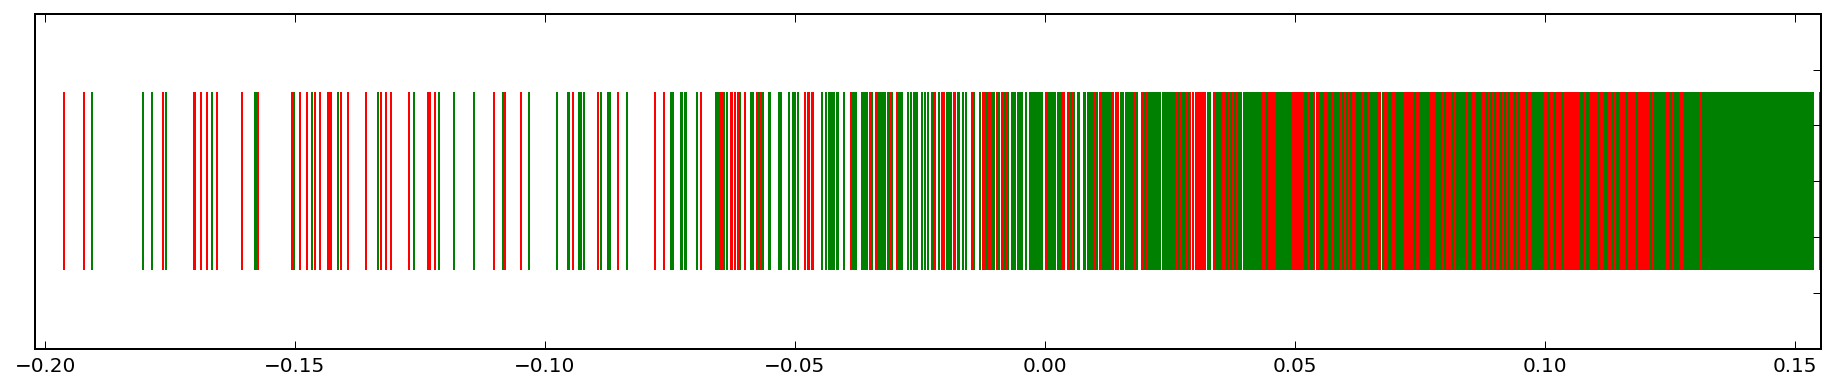

In [117]:
normaly_score, anomaly_score = exp.Solve(IsolationForest(1000), DF, DF_test[~ans], DF_test[ans])

такс, пора доставать стандарт скэйлер!

In [118]:
for c in DF.columns:
    DF_test[c] = (DF_test[c] - DF[c].min()) / (DF[c].max() - DF[c].min())
    DF[c] = (DF[c] - DF[c].min()) / (DF[c].max() - DF[c].min())

AUC-ROC score:  0.58445814978


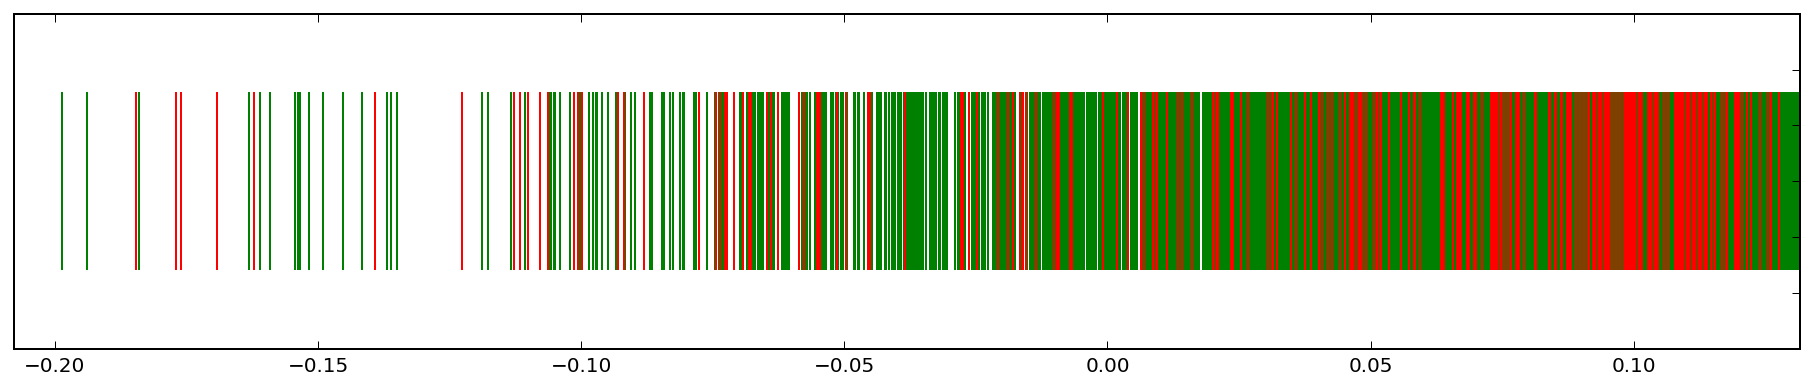

In [119]:
normaly_score, anomaly_score = exp.Solve(exp.modIsolationForest(1000), DF, DF_test[~ans], DF_test[ans])

AUC-ROC score:  0.774051604783


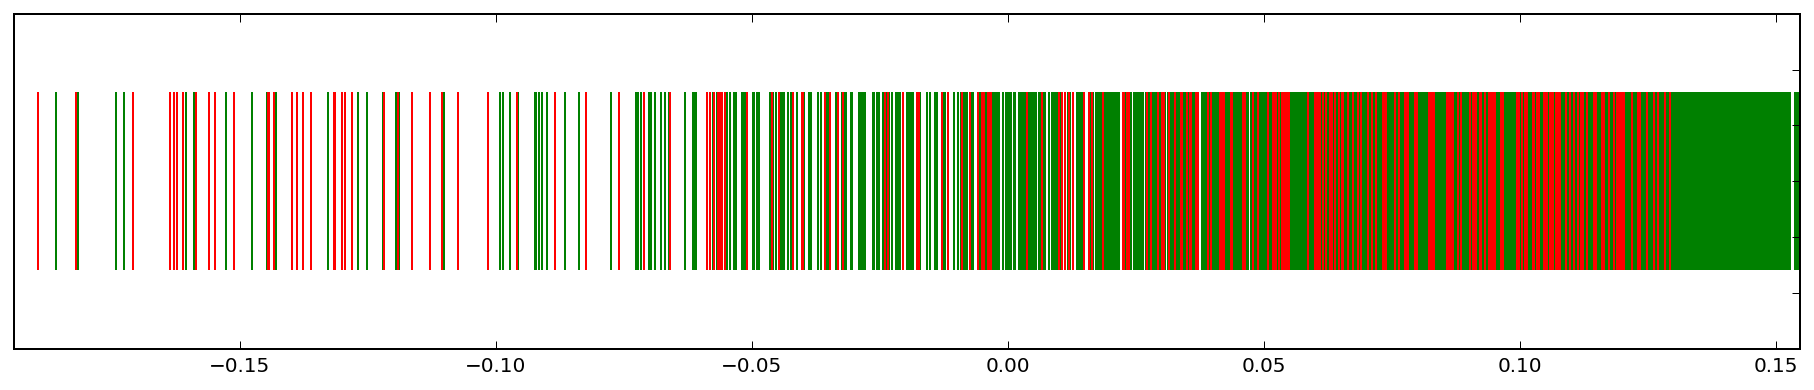

In [120]:
normaly_score, anomaly_score = exp.Solve(IsolationForest(1000), DF, DF_test[~ans], DF_test[ans])

:/

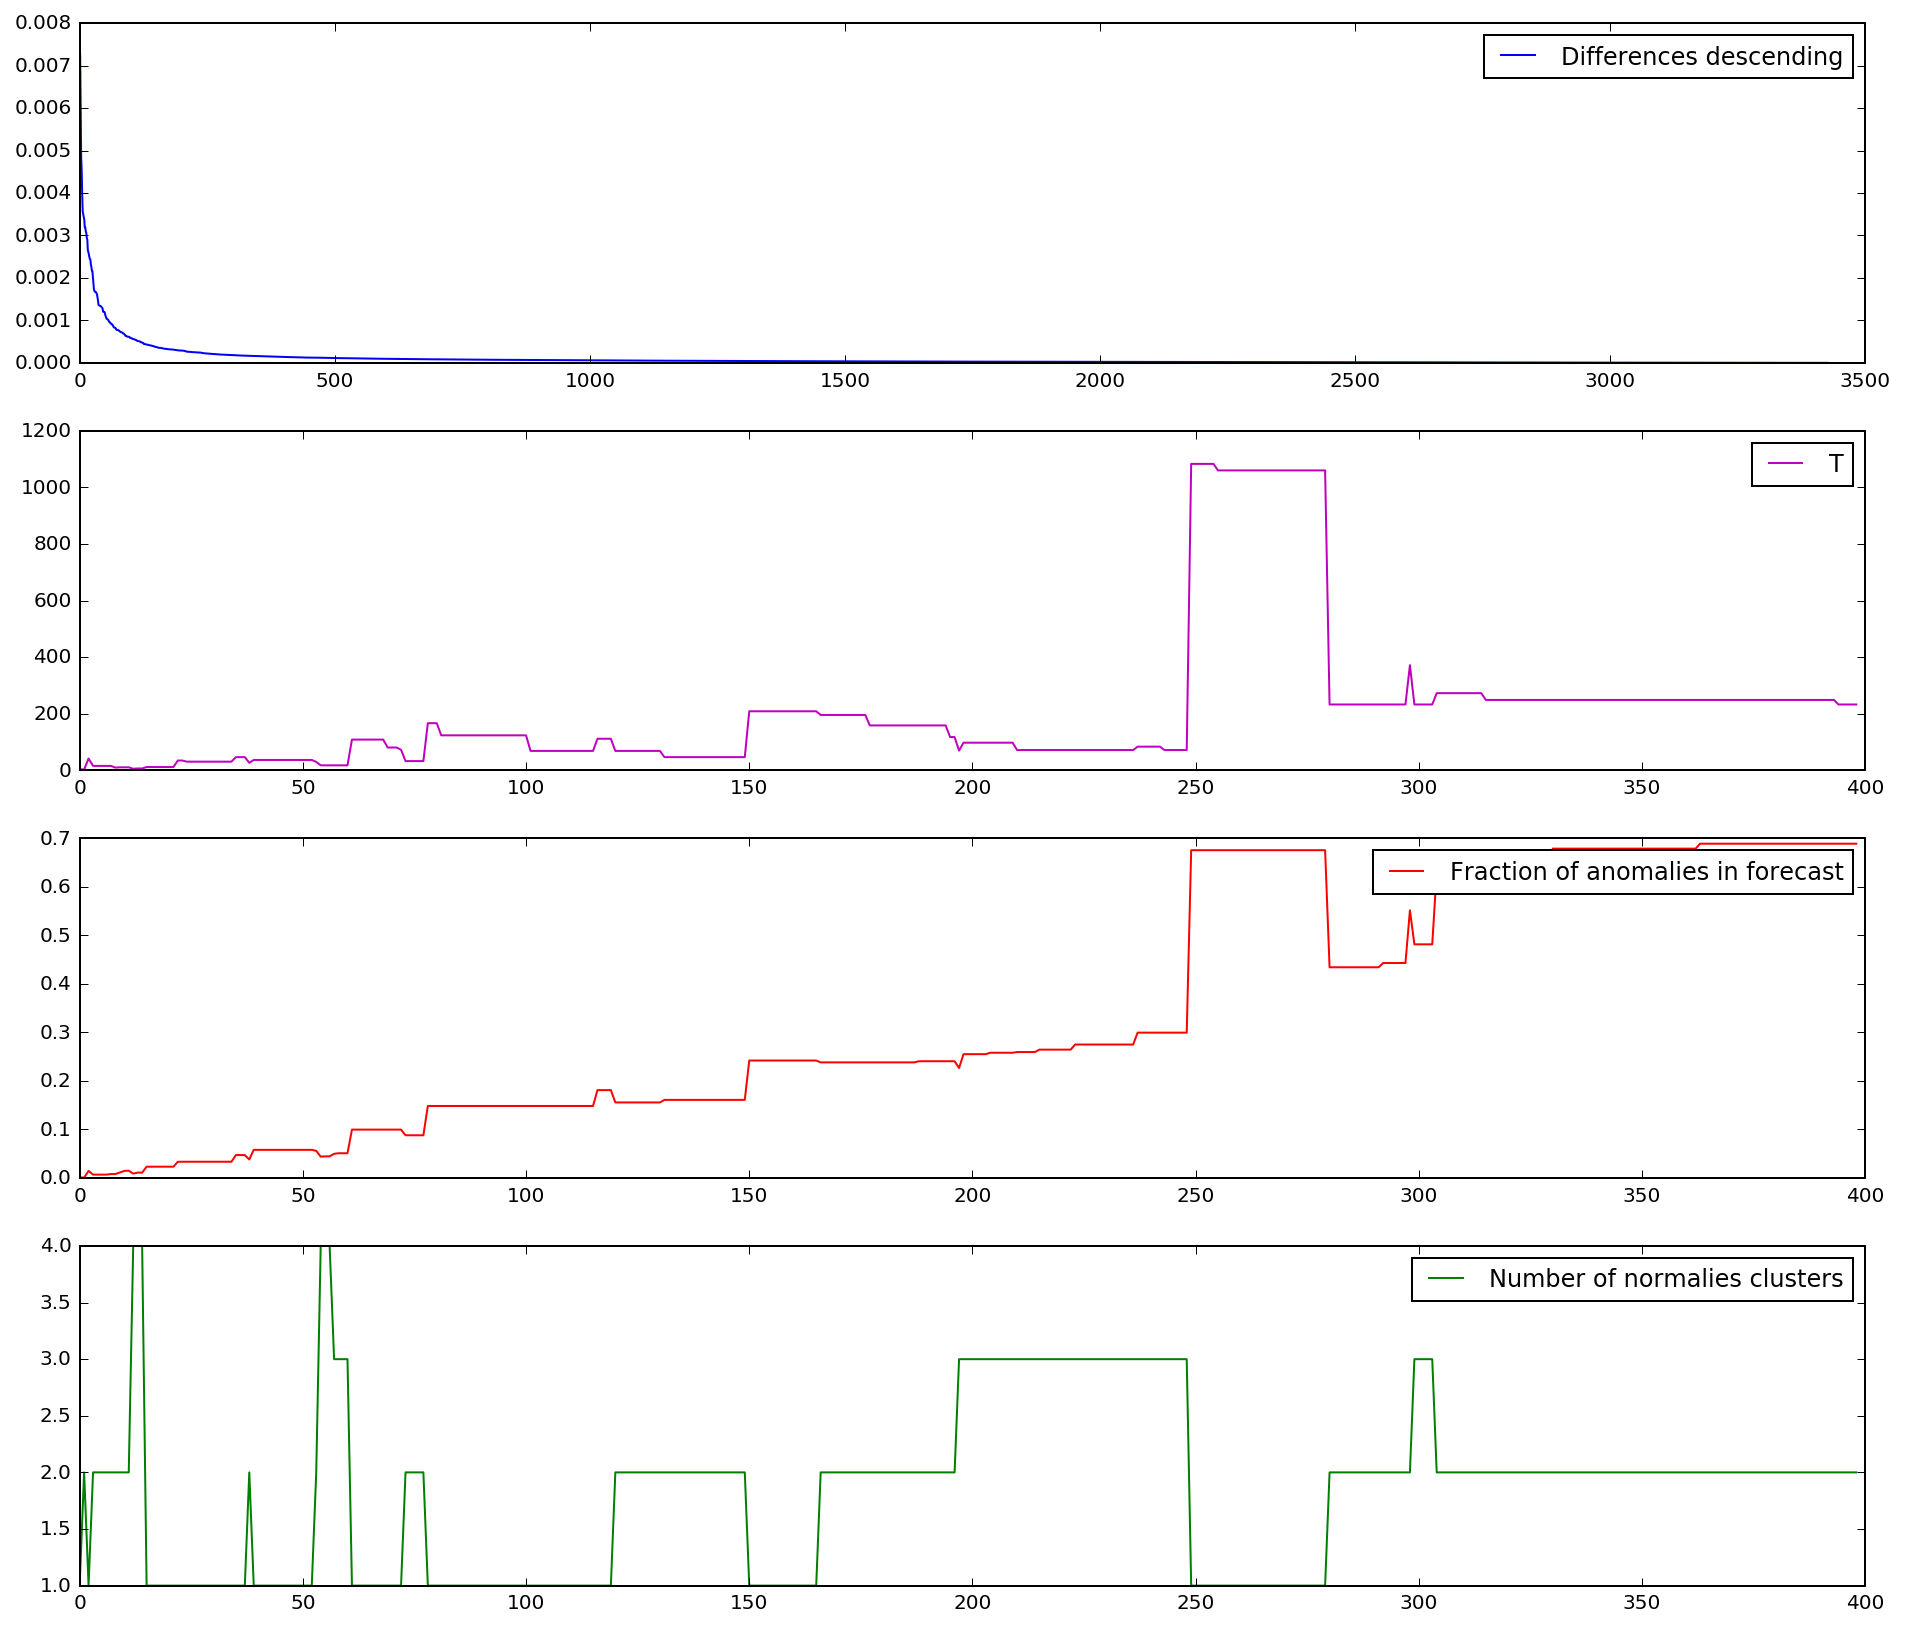

In [121]:
exp.analize_threshold(normaly_score, anomaly_score, 400)

In [122]:
exp.submit_variants(normaly_score, anomaly_score, 0.5)

variant: n_splits= 1 T =  5 , anom_frac =  0.0014585764294
variant: n_splits= 3 T =  42 , anom_frac =  0.014585764294
variant: n_splits= 38 T =  47 , anom_frac =  0.0472578763127
variant: n_splits= 53 T =  37 , anom_frac =  0.0580513418903
variant: n_splits= 73 T =  73 , anom_frac =  0.0997666277713
variant: n_splits= 120 T =  112 , anom_frac =  0.181155192532
variant: n_splits= 166 T =  209 , anom_frac =  0.242123687281


хм, вообще сказано, что на трейне как раз 7% аномалий... ну вот 24% это уже много

T =  73
Anomalies Fraction =  0.0997666277713 %


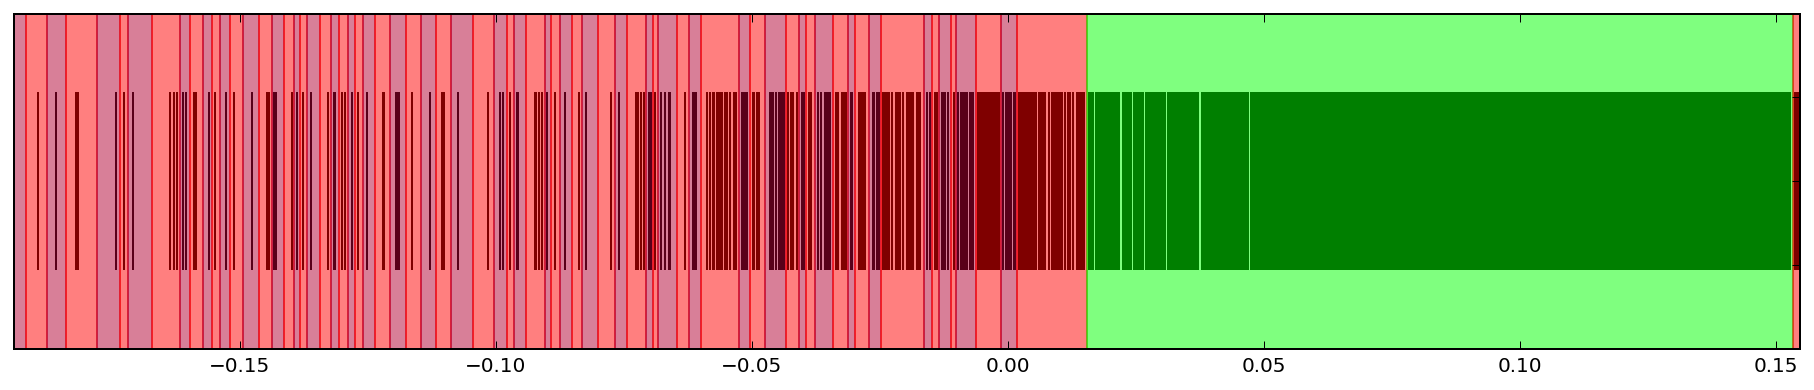

In [123]:
f = exp.apply_threshold(normaly_score, anomaly_score, 73)

In [124]:
exp.f_measure(np.append(np.zeros_like(normaly_score), np.ones_like(anomaly_score)), f)

precision =  0.233918128655
recall =  0.32
f-measure =  0.27027027027


0.27027027027027023

Теперь сколько потенциально можно было выжать:

Potential max f-measure =  0.290322580645  (thr =  -0.00335183033897 )


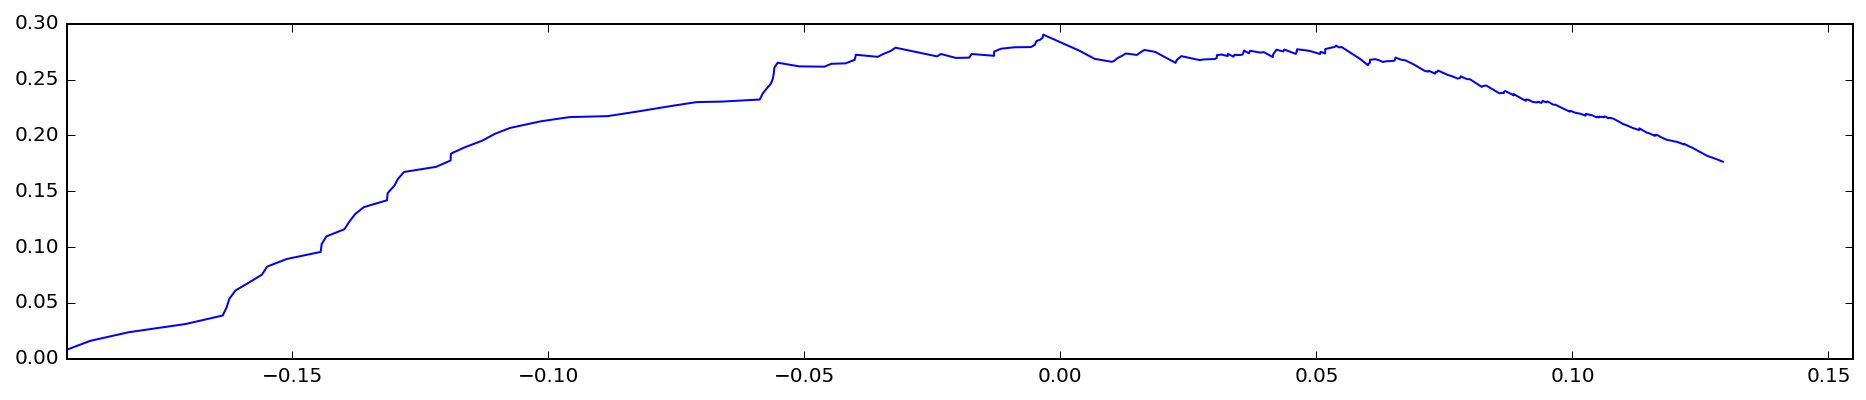

In [125]:
exp.potential_f_measure(normaly_score, anomaly_score)

о_О, точки с высоким anomaly_score что ли на самом деле аномалии? как это так вообще?